In [1]:
# Install the required packages
!pip install bar_chart_race
!pip install statsmodels
!pip install bokeh
!pip install sktime
!pip install vaderSentiment
!pip install tslearn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import request library

import math
import spacy
import warnings
import datetime
import pandas as pd
import numpy as np
import collections
import seaborn as sns
import scipy.stats as stats
import bar_chart_race as bcr
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.formula.api as smf
from tslearn.utils import to_sktime_dataset as sktdata
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster

# from bokeh.plotting import figure
# from bokeh.io import show, output_file
# from bokeh.models import TabPanel, Tabs, Label
# from bokeh.models import Span, ColumnDataSource

from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.base import ForecastingHorizon
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

/Users/huangweijun/opt/anaconda3/envs/python_jupyter/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
# Load ratings data from BeerAdvocate
df_rating_ba = pd.read_csv('./data/after_pro_data_ba.csv')
df_rating_ba = df_rating_ba.drop(columns=['Unnamed: 0'])
print(f'Currently, there are {len(df_rating_ba)} ratings on BeerAdvocate website')
#df_rating_ba.head()

Currently, there are 6264473 ratings on BeerAdvocate website


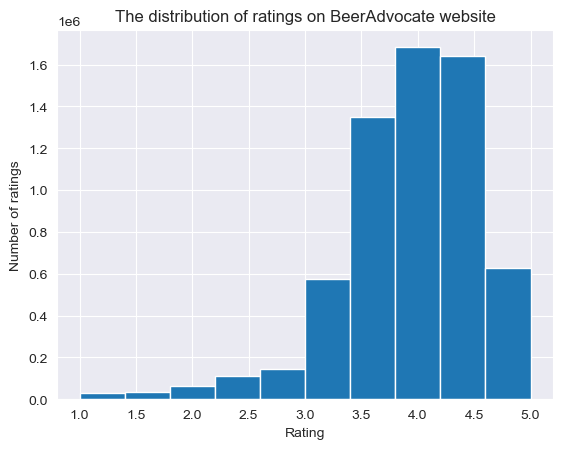

In [4]:
# Observes the distribution of ratings
df_rating_ba.rating.plot.hist()
plt.title('The distribution of ratings on BeerAdvocate website')
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.show()

From the histogram, we can see that the ratings are normally distributed. Most of the ratings are between 3.5 and 4.5.

### Handle the missing value and initial data filtering

In this part, we will handle the missing value and initial data filtering.

In [5]:
# The scoring attribute
column_ = ['appearance', 'aroma', 'palate', 'taste', 'overall']
print(f'There are {df_rating_ba [column_].isna().any(axis = 1).value_counts()[1]} rows have NAN values in BeerAdvocate')
print(f'There are {np.sum(df_rating_ba [column_].isna().sum(axis = 1)==5)} rows with 5 NAN values in BeerAdvocate')
compare_ba = df_rating_ba[df_rating_ba[column_].isna().any(axis = 1)]
compare_ba['rating'].describe()

There are 2971642 rows have NAN values in BeerAdvocate
There are 2971642 rows with 5 NAN values in BeerAdvocate


count    2.971642e+06
mean     3.902421e+00
std      6.835105e-01
min      1.000000e+00
25%      3.500000e+00
50%      4.000000e+00
75%      4.250000e+00
max      5.000000e+00
Name: rating, dtype: float64

Here we found if there is no overall score, there wouldn't be detailed scores about one beer. We also check the website manually, and found that we should rate the appearance, aroma, palate, taste, overall together.
However, these data all have the rating values. We don't think that these data are useful since we want to find some relationship of the detailed score to the rating and other perspectives. And since we will still have very large amout data after deleting them, we will just simply delete them.

In [6]:
#Delete all meaningless lines
df_rating_ba = df_rating_ba[~df_rating_ba[column_].isna().any(axis = 1)]
df_rating_ba.shape

(3292831, 17)

In [7]:
#spilt the user_id in BeerAdvocate
def str_split(data):
    return data.split('.')[1]
df_rating_ba['user_id'] = df_rating_ba['user_id'].apply(str_split)
df_rating_ba.head()

beer_name  beer_id                brewery_name  brewery_id  \
0  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
1  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
2  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
3  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
4  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   

           style  abv        date        user_name  user_id  appearance  \
0  Irish Red Ale  3.8  1500112800  GregKobeArntz24  1206160         4.5   
1  Irish Red Ale  3.8  1483182000           awjess  1185716         4.5   
2  Irish Red Ale  3.8  1468317600          fr0wn3r   862994         3.0   
3  Irish Red Ale  3.8  1459418400       Fatehunter   326927         4.0   
4  Irish Red Ale  3.8  1450263600           MTLDOG   920333         4.5   

   aroma  palate  taste  overall  rating  \
0   4.75    4.25    4.5     4.50    4.54   
1   4.00    4.25    4.0     4.25    4.11   
2   3.25    3.00    3.0     3.00    3.06   
3   3.25    4.00    3.5     3.50    3.52   
4   3.75    4.00    3.0     3.75    3.52   

                                                text  review  
0                                                NaN   False  
1  Look - Has a nice foamy head,   Feel - Creamy ...   False  
2                                                NaN   False  
3  Pours a finger of head on a hazy darker straw ...    True  
4                                                NaN   False

### Datasets preparation and more filtering
We first map the scale of each rating to 0-5 to make a consistency between the two datasets.


In [8]:
# Map the scale of each rating to 0-5
column_list = ['appearance', 'aroma', 'palate', 'taste', 'overall','rating']
list_value = df_rating_ba[column_list].values
min_max_scaler = preprocessing.MinMaxScaler()
list_value_scaler = min_max_scaler.fit_transform(list_value) * 5
data_temp_ba = pd.DataFrame(list_value_scaler,columns=column_list,index = df_rating_ba.index)
df_rating_ba[column_list] = data_temp_ba

df_rating_ba.head()

beer_name  beer_id                brewery_name  brewery_id  \
0  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
1  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
2  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
3  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   
4  Caffrey's Irish Ale      825  Thomas Caffrey Brewing Co.         297   

           style  abv        date        user_name  user_id  appearance  \
0  Irish Red Ale  3.8  1500112800  GregKobeArntz24  1206160       4.375   
1  Irish Red Ale  3.8  1483182000           awjess  1185716       4.375   
2  Irish Red Ale  3.8  1468317600          fr0wn3r   862994       2.500   
3  Irish Red Ale  3.8  1459418400       Fatehunter   326927       3.750   
4  Irish Red Ale  3.8  1450263600           MTLDOG   920333       4.375   

    aroma  palate  taste  overall  rating  \
0  4.6875  4.0625  4.375   4.3750  4.4250   
1  3.7500  4.0625  3.750   4.0625  3.8875   
2  2.8125  2.5000  2.500   2.5000  2.5750   
3  2.8125  3.7500  3.125   3.1250  3.1500   
4  3.4375  3.7500  2.500   3.4375  3.1500   

                                                text  review  
0                                                NaN   False  
1  Look - Has a nice foamy head,   Feel - Creamy ...   False  
2                                                NaN   False  
3  Pours a finger of head on a hazy darker straw ...    True  
4                                                NaN   False

By doing some simple regression study we find there exist perfect linear relationship between 'overall', 'aroma', 'palate', 'taste', 'overall', 'rating'.

In [9]:
# Use linear regression to fit our data
mod_ba = smf.ols(formula='rating ~appearance + aroma + palate + taste + overall',data = df_rating_ba)
res_ba = mod_ba.fit()
print(res_ba.summary())
print(f'The R-squared is 1.000 so it is of perfect linear relationship.')

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.904e+10
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        15:10:15   Log-Likelihood:             1.4883e+07
No. Observations:             3292831   AIC:                        -2.977e+07
Df Residuals:                 3292825   BIC:                        -2.977e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003    8.3e-06     37.210      0.0

We also find that there exists some ratings that the overall score exceeds the average of the other 4 features(can do this due to the perfect linear relationship). We consider this situation as invalid ratings. Because in common sense, if the detailed features of a beer is good/bad the overall will not be bad/good. And we set the difference threshold to 1.5(in scale of 5).

Besides, we also could notice that the coefficient of the taste is higher than the other features. So we could conclude that the taste is the most important feature of a beer. And we will use this conclusion in our future analysis.

In [10]:
# Remove the meaningless ratings
df_rating_ba['average'] = df_rating_ba[['appearance','aroma','palate','taste']].mean(axis = 1)
df_rating_ba['diff'] = np.abs(df_rating_ba['overall']-df_rating_ba['average'])
df_rating_ba = df_rating_ba[df_rating_ba['diff'] <1.5]
df_rating_ba = df_rating_ba.drop(columns=['average','diff'])
df_rating_ba.shape

(3266748, 17)

In addition, our analysis will based on the review text later, so we just consider the review as invalid, if there is no text in the review column.

In [11]:
df_rating_ba = df_rating_ba[~df_rating_ba['review']==False]
df_rating_ba.shape

(1855976, 17)

In [12]:
# Load user data from BeerAdvocate
df_user_ba = pd.read_csv('./data/BeerAdvocate/users.csv')
df_user_ba['user_id'] = df_user_ba['user_id'].apply(str_split)
df_user_ba.head()

nbr_ratings  nbr_reviews user_id        user_name        joined  \
0         7820          465  184925          nmann08  1.199704e+09   
1         2521         2504  163714      StJamesGate  1.191838e+09   
2         1797         1143   19527          mdagnew  1.116410e+09   
3           31           31   10867  helloloser12345  1.101380e+09   
4          604          604    3708       cypressbob  1.069326e+09   

                    location  
0  United States, Washington  
1    United States, New York  
2           Northern Ireland  
3           Northern Ireland  
4           Northern Ireland

In [13]:
# Load beer data from BeerAdvocate
df_beer_ba = pd.read_csv('./data/BeerAdvocate/beers.csv')
df_beer_ba.head()

beer_id           beer_name  brewery_id            brewery_name  \
0   166064    Nashe Moskovskoe       39912  Abdysh-Ata (Абдыш Ата)   
1   166065     Nashe Pivovskoe       39912  Abdysh-Ata (Абдыш Ата)   
2   166066  Nashe Shakhterskoe       39912  Abdysh-Ata (Абдыш Ата)   
3   166067  Nashe Zhigulevskoe       39912  Abdysh-Ata (Абдыш Ата)   
4   166063              Zhivoe       39912  Abdysh-Ata (Абдыш Ата)   

             style  nbr_ratings  nbr_reviews  avg  ba_score  bros_score  abv  \
0  Euro Pale Lager            0            0  NaN       NaN         NaN  4.7   
1  Euro Pale Lager            0            0  NaN       NaN         NaN  3.8   
2  Euro Pale Lager            0            0  NaN       NaN         NaN  4.8   
3  Euro Pale Lager            0            0  NaN       NaN         NaN  4.0   
4  Euro Pale Lager            0            0  NaN       NaN         NaN  4.5   

   avg_computed  zscore  nbr_matched_valid_ratings  avg_matched_valid_ratings  
0           NaN     NaN                          0                        NaN  
1           NaN     NaN                          0                        NaN  
2           NaN     NaN                          0                        NaN  
3           NaN     NaN                          0                        NaN  
4           NaN     NaN                          0                        NaN

In [14]:
# Load brewery data from BeerAdvocate
df_brewery_ba = pd.read_csv('./data/BeerAdvocate/breweries.csv')
df_brewery_ba.head()

id    location                    name  nbr_beers
0  39912  Kyrgyzstan  Abdysh-Ata (Абдыш Ата)          5
1  39913  Kyrgyzstan             Arpa (АРПА)          1
2  39914  Kyrgyzstan               Bear Beer          4
3  39915  Kyrgyzstan             Blonder Pub          4
4  39916  Kyrgyzstan            Kellers Bier          2

Merge data based on user id in order to get users' location

In [15]:
#user_region = df_user_ba[['user_id', 'location']]
region_ba = pd.merge(df_rating_ba, df_user_ba, how="left", left_on='user_id', right_on='user_id')

In [16]:
# Count the number of ratings for each location
# And get the region list so that we can use for later analysis
region_agg = region_ba[['location', 'beer_id']].groupby('location').agg('count')
region_agg = pd.DataFrame(region_agg.to_records())
region_agg.rename(columns={'beer_id':'count'}, inplace=True)
region_agg = region_agg.sort_values(by=['count'], ascending=False)
region_agg.reset_index(inplace=True, drop=True)
# Print top 20 region
region_agg.head(20)

location   count
0     United States, Pennsylvania  148288
1       United States, California  137656
2         United States, New York  115045
3         United States, Illinois  100887
4    United States, Massachusetts   97904
5             United States, Ohio   83572
6            United States, Texas   66150
7                          Canada   64502
8       United States, New Jersey   61711
9         United States, Virginia   57073
10       United States, Minnesota   56909
11      United States, Washington   53248
12  United States, North Carolina   49830
13         United States, Florida   49441
14        United States, Michigan   48911
15        United States, Colorado   46906
16         United States, Georgia   40426
17        United States, Maryland   40238
18       United States, Wisconsin   35537
19     United States, Connecticut   33720

We can see that the top 20 regions are all in the US. So we will just consider the US data in our analysis.

## Data Visualization and Choose the popular beers
#### ABV

First let us get a sense of how the ABV is like in the dataset.

The average abv% of beers from BeerAdvocate is 7.37%.


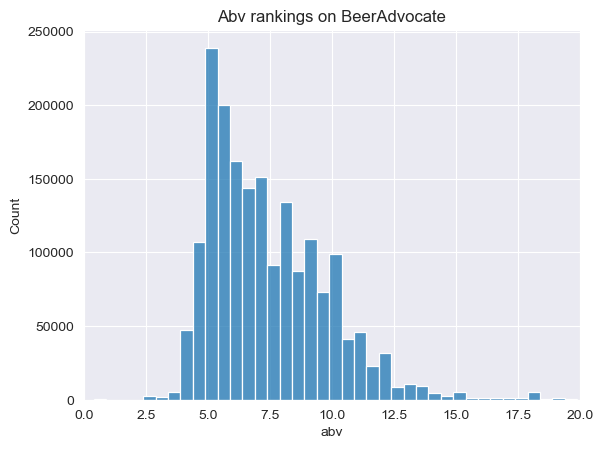

In [17]:
# Plot the distribution of ABV
avg_ba_abv = region_ba.abv.mean()
avg_ba_abv = round(avg_ba_abv, 2)
print(f'The average abv% of beers from BeerAdvocate is {avg_ba_abv}%.')
fig, ax = plt.subplots()
ax.set_xlim(0, 20)
sns.histplot(region_ba.abv, binwidth=0.5, ax=ax)
plt.title("Abv rankings on BeerAdvocate")
plt.show()

Observe: most of the beers have abv% between 5% and 10%.

Since we want to make the most popular beer as our motivation, we just study the beers that has abv from its 25% quantile to 75% quantile.

In [18]:
region_ba_filtered = region_ba[(region_ba.abv.quantile(0.25) <= region_ba.abv) & (region_ba.abv <= region_ba.abv.quantile(0.75))]
region_ba_filtered.shape

(1007708, 22)

#### Style
Then get a general feeling of style distribution

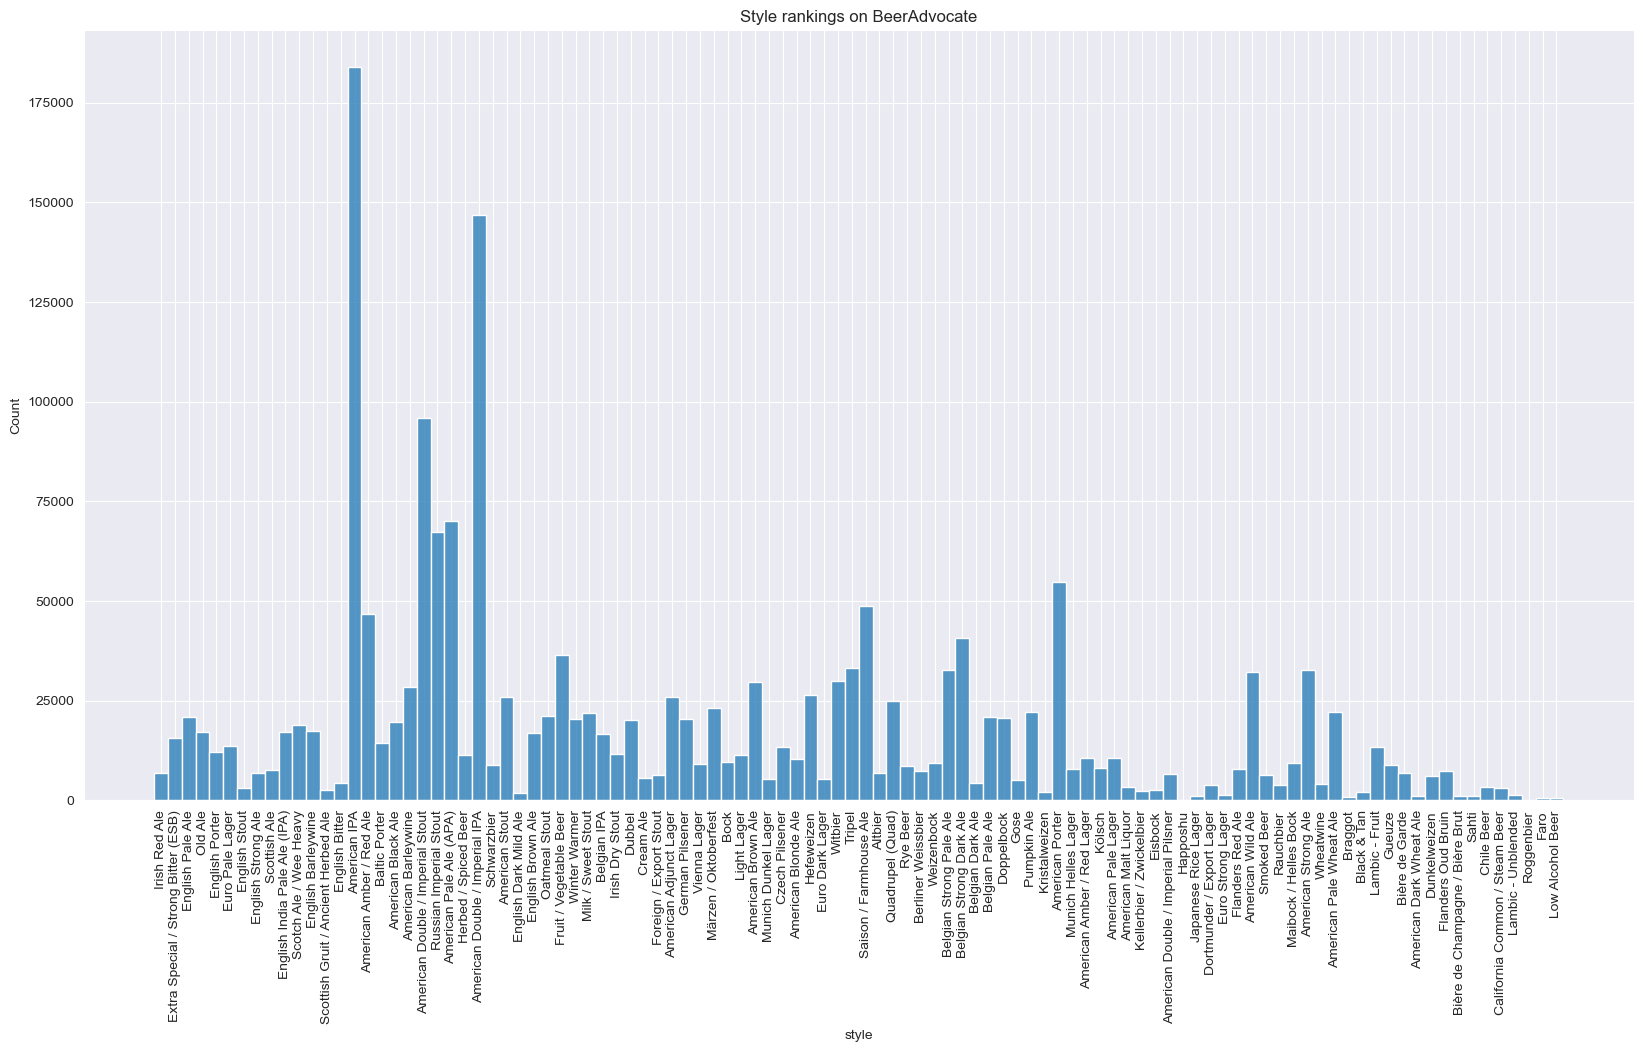

In [19]:
plt.figure(figsize=(20,10))
sns.histplot(data=region_ba['style'])
plt.xticks(rotation=90)
plt.title("Style rankings on BeerAdvocate")
plt.show()

In [20]:
# Get the style_list for later analysis
style_list = region_ba[['style','beer_id']].groupby('style').agg('count')
style_list.rename(columns={'beer_id': 'count'}, inplace=True)
style_list = style_list.sort_values(by='count', ascending=False)
style_list.reset_index(inplace=True)
style_list.head(10)

style   count
0                      American IPA  183955
1    American Double / Imperial IPA  146798
2  American Double / Imperial Stout   95908
3           American Pale Ale (APA)   70148
4            Russian Imperial Stout   67380
5                   American Porter   54793
6            Saison / Farmhouse Ale   48686
7          American Amber / Red Ale   46612
8           Belgian Strong Dark Ale   40571
9            Fruit / Vegetable Beer   36383

In here, we obtain the most popular 10 styles of beers in BeerAdvocate. And we will just consider the beers in these 10 styles in our analysis.

In [21]:
popular_styles = style_list['style'][:10].to_list()
region_ba_filtered = region_ba_filtered[region_ba_filtered['style'].isin(popular_styles)]
region_ba_filtered.shape

(472850, 22)

## For user recommendation(Not on the website)
**This part is a piece of code where we can have a try to find some examples for our analysis.**

define some variables that the user can input, then our model will return the recommended beer

In [22]:
abv=5.0
error_range_abv = 0.5
style = region_ba['style'].unique().tolist()[0]
region = region_agg['location'].tolist()[0]
num_of_results_to_show = 10
How = ['popularity', 'Rating']
how = {'popularity': 0, 'Rating': 1}

recommendation based on  popularity

In [23]:
df_beer_ba.head()

beer_id           beer_name  brewery_id            brewery_name  \
0   166064    Nashe Moskovskoe       39912  Abdysh-Ata (Абдыш Ата)   
1   166065     Nashe Pivovskoe       39912  Abdysh-Ata (Абдыш Ата)   
2   166066  Nashe Shakhterskoe       39912  Abdysh-Ata (Абдыш Ата)   
3   166067  Nashe Zhigulevskoe       39912  Abdysh-Ata (Абдыш Ата)   
4   166063              Zhivoe       39912  Abdysh-Ata (Абдыш Ата)   

             style  nbr_ratings  nbr_reviews  avg  ba_score  bros_score  abv  \
0  Euro Pale Lager            0            0  NaN       NaN         NaN  4.7   
1  Euro Pale Lager            0            0  NaN       NaN         NaN  3.8   
2  Euro Pale Lager            0            0  NaN       NaN         NaN  4.8   
3  Euro Pale Lager            0            0  NaN       NaN         NaN  4.0   
4  Euro Pale Lager            0            0  NaN       NaN         NaN  4.5   

   avg_computed  zscore  nbr_matched_valid_ratings  avg_matched_valid_ratings  
0           NaN     NaN                          0                        NaN  
1           NaN     NaN                          0                        NaN  
2           NaN     NaN                          0                        NaN  
3           NaN     NaN                          0                        NaN  
4           NaN     NaN                          0                        NaN

In [24]:
selected = df_beer_ba[df_beer_ba.abv.isin(np.linspace(abv-error_range_abv, abv+error_range_abv, 10))]

In [25]:
selected = selected[selected['style'] == style]
selected.sort_values(by='nbr_reviews', ascending=False, inplace=True)
selected_beer_id_by_popularity = selected.beer_id.tolist()[:num_of_results_to_show]
selected_beer_id_by_popularity

[29602, 16520, 1822, 71106, 43835, 47166, 2778, 7492, 9091, 79393]

recommendation based on rating_avg

In [26]:
selected = region_ba[region_ba.abv.isin(np.linspace(abv-error_range_abv, abv+error_range_abv, 10))]
selected = selected[selected['style'] == style]
selected_beer_avgRating = selected[['beer_id', 'rating']].groupby('beer_id').agg('mean')
selected_beer_avgRating.sort_values(by='rating', ascending=False, inplace=True)
selected_beer_avgRating.reset_index(inplace=True)
selected_beer_name_by_avgRating = df_beer_ba[df_beer_ba.beer_id.isin(selected_beer_avgRating['beer_id'].to_list()[:num_of_results_to_show])][['beer_id', 'beer_name']]
selected_beer_name_by_avgRating = selected_beer_name_by_avgRating.beer_id.to_list()
selected_beer_name_by_avgRating

[1822, 29602, 62182, 9091, 43835, 79393, 23052, 16520, 7492, 2778]

In [27]:
selected_id_list = [selected_beer_id_by_popularity, selected_beer_name_by_avgRating]

Here the ```selected_list``` is the beer info list that we may recommend to the user and ```selected_beer_name_by_How``` is the top ```num_of_results_to_show``` beer_id to show.

Then we want to analyze the review texts to get the top 5 keywords for user's reference.

## Sentiment Analysis and High-Freqeuncy word analysis for BeerAdvocate reviews


In this part, we will analyze the sentiment of BeerAdvocate reviews in order to determine whether the positive / negative proportion in review is related to the trend of beer popularity.

In [28]:
region_ba_filtered.shape

(472850, 22)

In [29]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df_sentiment_ba = region_ba_filtered.copy()

# Because some text just in type of float, we need to convert it to string
df_sentiment_ba.text = df_sentiment_ba.text.astype(str)

In [30]:
# Get sentiment score for each review
positive_list, negative_list, neutral_list = [], [], []
pos, neg, neu, compound = [], [], [], []

for i in range(df_sentiment_ba.shape[0]):
    text = df_sentiment_ba.iloc[i]['text']
    vs = analyzer.polarity_scores(text)
    positive = 1 if vs['compound'] >= 0.5 else 0
    negative = 1 if vs['compound'] <= -0.5 else 0
    neutral = 1 if vs['compound'] > -0.5 and vs['compound'] < 0.5 else 0
    # Set the threshold to be 0.5 and -0.5
    # to judge the whether sentiment of the reveiw text
    # is positive or negative
    positive_list.append(positive)
    negative_list.append(negative)
    neutral_list.append(neutral)
    pos.append(vs['pos'])
    neg.append(vs['neg'])
    neu.append(vs['neu'])
    compound.append(vs['compound'])

df_sentiment_ba['positive'] = positive_list
df_sentiment_ba['negative'] = negative_list
df_sentiment_ba['neutral'] = neutral_list
df_sentiment_ba['pos'] = pos
df_sentiment_ba['neg'] = neg
df_sentiment_ba['neu'] = neu


In [31]:
# Change to datetime
df_sentiment_ba['date'] = df_sentiment_ba.date.apply(lambda x: datetime.datetime.fromtimestamp(x).year)

### Fine the fraction of negative reviews in ```['American IPA', 'American Double / Imperial IPA', 'American Porter']```

In [32]:
# popular the names of beer styles
style_name = ['American IPA', 'American Double / Imperial IPA', 'American Porter']

# Choose the useful columns to boost the running speed
df_sentiment_ba_topStyle = pd.DataFrame(columns=['year', 'style', 'fraction_negative'])

for style in style_name:
    tmp = df_sentiment_ba[df_sentiment_ba['style'] == style]
    tmp_neg_nums = tmp[['date', 'negative']].groupby('date').agg('sum')['negative']
    tmp_nums = tmp[['date', 'beer_id']].groupby('date').agg('count')['beer_id']
    tmp = (tmp_neg_nums / tmp_nums).reset_index()
    df_sentiment_ba_topStyle.reset_index()
    tmp.columns = ['year', 'fraction_negative']
    tmp['style'] = style
    df_sentiment_ba_topStyle = pd.concat([df_sentiment_ba_topStyle, tmp])

In [33]:
df_sentiment_ba_topStyle

year                           style  fraction_negative
0   1998                    American IPA           0.000000
1   2000                    American IPA           0.000000
2   2001                    American IPA           0.024390
3   2002                    American IPA           0.043554
4   2003                    American IPA           0.036707
5   2004                    American IPA           0.030269
6   2005                    American IPA           0.030684
7   2006                    American IPA           0.025217
8   2007                    American IPA           0.023424
9   2008                    American IPA           0.023872
10  2009                    American IPA           0.027045
11  2010                    American IPA           0.022247
12  2011                    American IPA           0.025854
13  2012                    American IPA           0.024232
14  2013                    American IPA           0.026811
15  2014                    American IPA           0.025061
16  2015                    American IPA           0.029539
17  2016                    American IPA           0.030389
18  2017                    American IPA           0.030649
0   2001  American Double / Imperial IPA           0.000000
1   2002  American Double / Imperial IPA           0.032609
2   2003  American Double / Imperial IPA           0.031746
3   2004  American Double / Imperial IPA           0.031915
4   2005  American Double / Imperial IPA           0.031100
5   2006  American Double / Imperial IPA           0.022006
6   2007  American Double / Imperial IPA           0.025695
7   2008  American Double / Imperial IPA           0.021880
8   2009  American Double / Imperial IPA           0.020836
9   2010  American Double / Imperial IPA           0.023998
10  2011  American Double / Imperial IPA           0.022874
11  2012  American Double / Imperial IPA           0.023917
12  2013  American Double / Imperial IPA           0.021161
13  2014  American Double / Imperial IPA           0.022121
14  2015  American Double / Imperial IPA           0.028760
15  2016  American Double / Imperial IPA           0.026054
16  2017  American Double / Imperial IPA           0.023172
0   1998                 American Porter           0.000000
1   1999                 American Porter           0.000000
2   2000                 American Porter           0.000000
3   2001                 American Porter           0.000000
4   2002                 American Porter           0.018182
5   2003                 American Porter           0.028050
6   2004                 American Porter           0.022638
7   2005                 American Porter           0.023041
8   2006                 American Porter           0.026998
9   2007                 American Porter           0.014467
10  2008                 American Porter           0.018540
11  2009                 American Porter           0.013785
12  2010                 American Porter           0.016312
13  2011                 American Porter           0.015925
14  2012                 American Porter           0.021586
15  2013                 American Porter           0.018376
16  2014                 American Porter           0.024709
17  2015                 American Porter           0.030952
18  2016                 American Porter           0.027136
19  2017                 American Porter           0.020000

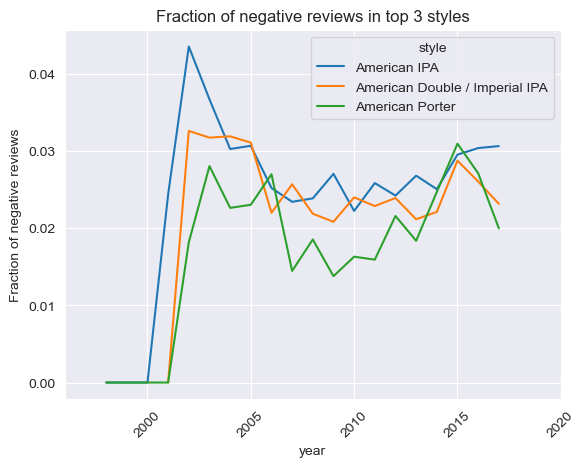

In [34]:
df_sentiment_ba_topStyle['year'] = df_sentiment_ba_topStyle['year'].astype(int)

sns.lineplot(data=df_sentiment_ba_topStyle, x='year', y='fraction_negative', hue='style')
plt.title('Fraction of negative reviews in top 3 styles')
plt.ylabel('Fraction of negative reviews')
plt.xticks(rotation=45)
plt.xlim(1996, 2020)
plt.show()

In [35]:
df_sentiment_ba.shape

(472850, 28)

Observe the plot above, we can see that the fraction of negative review in American Porter increasing between 2010 and 2015. However, the fraction of negative review in American IPA and American Double / Imperial IPA is maintain a stable level.

In [36]:
df_sentiment_ba_topStyle = pd.DataFrame(columns=['year', 'style', 'fraction_positive'])


for style in style_name:
    tmp = df_sentiment_ba[df_sentiment_ba['style'] == style]
    tmp_neg_nums = tmp[['date', 'positive']].groupby('date').agg('sum')['positive']
    tmp_nums = tmp[['date', 'beer_id']].groupby('date').agg('count')['beer_id']
    tmp = (tmp_neg_nums / tmp_nums).reset_index()
    df_sentiment_ba_topStyle.reset_index()
    tmp.columns = ['year', 'fraction_positive']
    tmp['style'] = style
    df_sentiment_ba_topStyle = pd.concat([df_sentiment_ba_topStyle, tmp])

In [37]:
df_sentiment_ba_topStyle

year                           style  fraction_positive
0   1998                    American IPA           0.000000
1   2000                    American IPA           0.000000
2   2001                    American IPA           0.560976
3   2002                    American IPA           0.796167
4   2003                    American IPA           0.741379
5   2004                    American IPA           0.784422
6   2005                    American IPA           0.773524
7   2006                    American IPA           0.737217
8   2007                    American IPA           0.736057
9   2008                    American IPA           0.726657
10  2009                    American IPA           0.701714
11  2010                    American IPA           0.694304
12  2011                    American IPA           0.680323
13  2012                    American IPA           0.653783
14  2013                    American IPA           0.657432
15  2014                    American IPA           0.652945
16  2015                    American IPA           0.657792
17  2016                    American IPA           0.647839
18  2017                    American IPA           0.630765
0   2001  American Double / Imperial IPA           0.666667
1   2002  American Double / Imperial IPA           0.815217
2   2003  American Double / Imperial IPA           0.774603
3   2004  American Double / Imperial IPA           0.770517
4   2005  American Double / Imperial IPA           0.755981
5   2006  American Double / Imperial IPA           0.774309
6   2007  American Double / Imperial IPA           0.745864
7   2008  American Double / Imperial IPA           0.743488
8   2009  American Double / Imperial IPA           0.722327
9   2010  American Double / Imperial IPA           0.704334
10  2011  American Double / Imperial IPA           0.694158
11  2012  American Double / Imperial IPA           0.666393
12  2013  American Double / Imperial IPA           0.673244
13  2014  American Double / Imperial IPA           0.685467
14  2015  American Double / Imperial IPA           0.675819
15  2016  American Double / Imperial IPA           0.685057
16  2017  American Double / Imperial IPA           0.683708
0   1998                 American Porter           0.000000
1   1999                 American Porter           0.000000
2   2000                 American Porter           0.000000
3   2001                 American Porter           0.777778
4   2002                 American Porter           0.774545
5   2003                 American Porter           0.753156
6   2004                 American Porter           0.778543
7   2005                 American Porter           0.756528
8   2006                 American Porter           0.724082
9   2007                 American Porter           0.730108
10  2008                 American Porter           0.716771
11  2009                 American Porter           0.692866
12  2010                 American Porter           0.690757
13  2011                 American Porter           0.690753
14  2012                 American Porter           0.653836
15  2013                 American Porter           0.656532
16  2014                 American Porter           0.635897
17  2015                 American Porter           0.646259
18  2016                 American Porter           0.654271
19  2017                 American Porter           0.647059

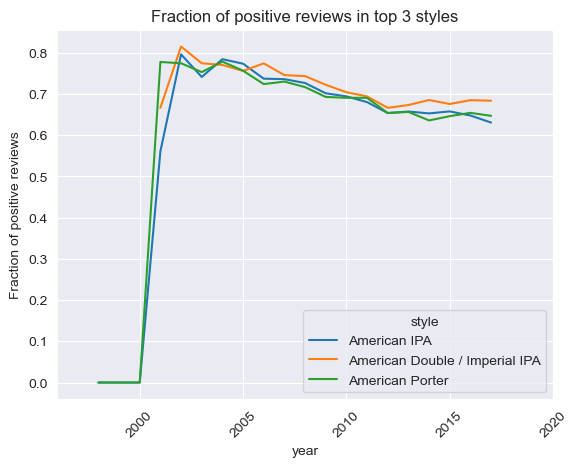

In [38]:
df_sentiment_ba_topStyle['year'] = df_sentiment_ba_topStyle['year'].astype(int)

sns.lineplot(data=df_sentiment_ba_topStyle, x='year', y='fraction_positive', hue='style')
plt.title('Fraction of positive reviews in top 3 styles')
plt.ylabel('Fraction of positive reviews')
plt.xticks(rotation=45)
plt.xlim(1996, 2020)
plt.show()

In here, we could notice that the fraction of positive reviews is slowly decreasing over time.

### Builde a linear regression model to predict the rating based on the sentiment score
Here We can check whether bad rating means negative sentiment, so that we can better filter out the negative reviews.

In [39]:
# Build linear regression model
mod = smf.ols(formula="overall ~ neg * neu * pos", data=df_sentiment_ba)
result = mod.fit()
print('RatingBeer Sentiment Analysis')
result.summary()

RatingBeer Sentiment Analysis


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     6066.
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        15:17:27   Log-Likelihood:            -4.8259e+05
No. Observations:              472850   AIC:                         9.652e+05
Df Residuals:                  472842   BIC:                         9.653e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.7978      2.521      1.903      0.057      -0.143       9.739
neg             1.1528      2.525      0.457      0.648      -3.795       6.101
neu            -1.1137      2.521     -0.442      0.659      -6.055       3.827
neg:neu        -9.4611      0.176    -53.622      0.000      -9.807      -9.115
pos            -0.8555      2.521     -0.339      0.734      -5.797       4.086
neg:pos         5.1564      1.229      4.197      0.000       2.748       7.565
neu:pos         1.4048      0.025     55.239      0.000       1.355       1.455
neg:neu:pos     7.3608      1.902      3.870      0.000       3.633      11.089
==============================================================================
Omnibus:                    57646.444   Durbin-Watson:                   1.454
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120432.695
Skew:                          -0.761   Prob(JB):                         0.00
Kurtosis:                       4.948   Cond. No.                     6.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We could notice that the R-Squared is too low, which means the sentiment score is not a good predictor for the rating.

### Find the most frequent ADJ word in the negative review text

In [40]:
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 15000000
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

def Find_Frequent_Words(text):

    """
    Find the most frequent words in the text
    Input: text (For short database)
    Output: a list of most frequent words
    """

    doc = nlp(text)
    doc = [token for token in doc if token.is_stop != True and token.is_punct != True]
    df_freq_words = pd.DataFrame(columns=['word','pos','count'])
    df_freq_words['word'] = [token.lemma_ for token in doc]
    df_freq_words['pos'] = [token.pos_ for token in doc]
    df_freq_words['count'] = 1
    df_freq_words.groupby(['word', 'pos']).agg('sum').reset_index().sort_values(by='count', ascending=False)

    return df_freq_words

In [41]:
example = 'I want you contact someone, The company is sending out leaflets to all its contacts'
Find_Frequent_Words(example)

word   pos  count
0     want  VERB      1
1  contact  VERB      1
2  company  NOUN      1
3     send  VERB      1
4  leaflet  NOUN      1
5  contact  NOUN      1

In [42]:
def Fine_Frequent_Words_Big(df):
    """
    Find the most frequent words in the text
    Input: df (For big database)
    Output: a list of most frequent words
    """

    df_freq_words = pd.DataFrame(columns=['word', 'count','pos'])
    for i in range(0, len(df), 1000):
        temp = df[i:i+1000]
        text = ''.join(temp['text'])
        df_freq_words_tmp = Find_Frequent_Words(text)
        df_freq_words = pd.concat([df_freq_words, df_freq_words_tmp], axis=0)
        df_freq_words = df_freq_words.groupby(['word','pos']).sum()
        df_freq_words = df_freq_words.sort_values(by='count', ascending=False)
        df_freq_words = df_freq_words.reset_index()
    return df_freq_words

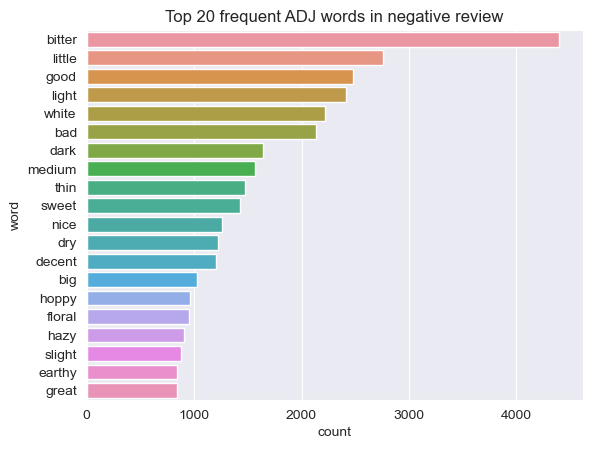

In [43]:
df_negative_review = df_sentiment_ba.copy()
df_negative_review = df_negative_review[(df_negative_review['negative'] == 1) & (df_negative_review['overall'] < 3.5)]

df_freq_word = Fine_Frequent_Words_Big(df_negative_review)

sns.barplot(x='count', y='word', data=df_freq_word[df_freq_word['pos'] == 'ADJ'].head(20))
plt.title('Top 20 frequent ADJ words in negative review')
plt.show()

We wanted to know the adjectives that appear most often in negative reviews and that contain what consumers are not satisfied with about these beers. The brewery can use these words to improve their beers. First we find the most frequent ADJ words, and we could notice that the word "bitter" is the most frequent word in the negative review. The brewery can use this word to improve their beers.

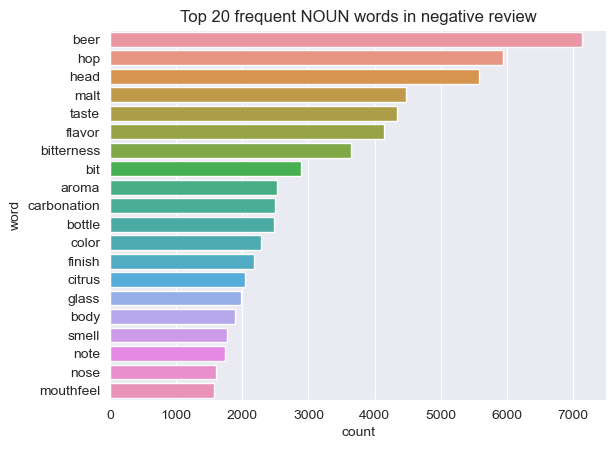

In [92]:
sns.barplot(x='count', y='word', data=df_freq_word[df_freq_word['pos'] == 'NOUN'].head(20))
plt.title('Top 20 frequent NOUN words in negative review')
plt.show()

Here we pick the most frequent NOUN words, we could notice that the word "flavor" and "taste" are appear often, which means the consumers are more focus on the taste of the beer.

### For each brewery, find the most frequent ADJ word

In [45]:
most_popular_brewery = list(region_ba_filtered['brewery_name'].value_counts().index[:5])

In [46]:
# Have a look at the breweries
most_popular_brewery

['Sierra Nevada Brewing Co.',
 'Dogfish Head Brewings & Eats',
 'Stone Brewing',
 'Lagunitas Brewing Company',
 'Founders Brewing Company']

We only keep the most popular brewery here, we also plot other breweries by adjusting the following code

In [47]:
# The most popular brewery
df_sentiment_ba_brewery = df_sentiment_ba[df_sentiment_ba['brewery_name'] == most_popular_brewery[0]]

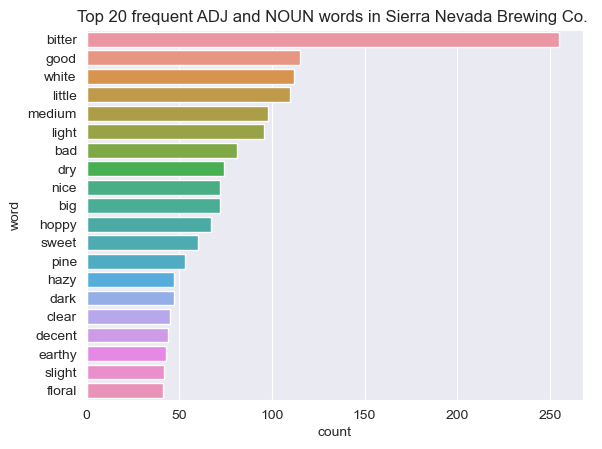

In [48]:
df_negative_review_brewery = df_sentiment_ba_brewery[df_sentiment_ba_brewery['negative'] == 1]

df_freq_word_brewery = Fine_Frequent_Words_Big(df_negative_review_brewery)
sns.barplot(x='count', y='word', data=df_freq_word_brewery[df_freq_word_brewery['pos'] == 'ADJ'].head(20))
plt.title(f'Top 20 frequent ADJ and NOUN words in {most_popular_brewery[0]} ')
plt.show()

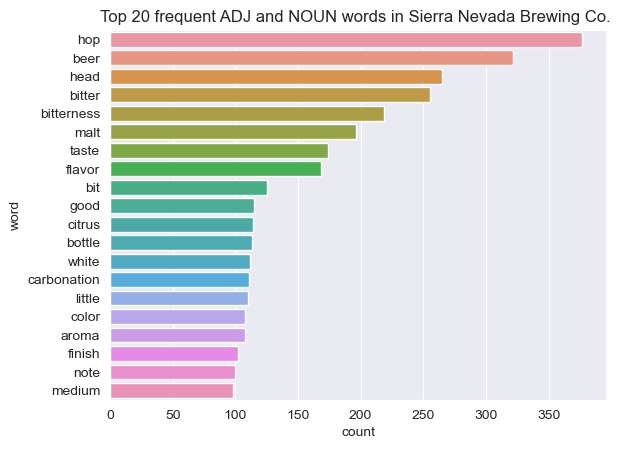

In [49]:
sns.barplot(x='count', y='word', data=df_freq_word_brewery[(df_freq_word_brewery['pos'] == 'ADJ') | (df_freq_word_brewery['pos'] == 'NOUN')].head(20))
plt.title(f'Top 20 frequent ADJ and NOUN words in {most_popular_brewery[0]} ')
plt.show()

### Find the most frequent ADJ word in most popular regions

In [50]:
region_ba_filtered.head()

beer_name  beer_id                   brewery_name  \
10373  Belhaven Twisted Thistle IPA    25989  Belhaven Brewery Company Ltd.   
10374  Belhaven Twisted Thistle IPA    25989  Belhaven Brewery Company Ltd.   
10375  Belhaven Twisted Thistle IPA    25989  Belhaven Brewery Company Ltd.   
10376  Belhaven Twisted Thistle IPA    25989  Belhaven Brewery Company Ltd.   
10377  Belhaven Twisted Thistle IPA    25989  Belhaven Brewery Company Ltd.   

       brewery_id         style  abv        date   user_name_x  user_id  \
10373         148  American IPA  6.1  1496570400         djura   544616   
10374         148  American IPA  6.1  1496484000         MJSFS   977888   
10375         148  American IPA  6.1  1488020400        Buck89   940400   
10376         148  American IPA  6.1  1484132400  Czequershuus   780649   
10377         148  American IPA  6.1  1482922800      Gardendk  1185249   

       appearance  ...   taste  overall  rating  \
10373      3.1250  ...  3.4375   3.4375  3.5375   
10374      3.4375  ...  2.5000   2.8125  2.6875   
10375      3.7500  ...  3.4375   3.4375  3.4625   
10376      3.4375  ...  3.7500   3.7500  3.6875   
10377      2.5000  ...  2.8125   2.8125  2.8000   

                                                    text  review nbr_ratings  \
10373  Found it here in Serbia, bottle 0,33 lA - Pale...    True         421   
10374  Bubbly sugary urine water. I'm confused how an...    True         742   
10375  Poured from a tap into a pint glass. A clear a...    True        1112   
10376  This beer pours pale amber with an average hea...    True        1011   
10377                                                  A    True          10   

       nbr_reviews   user_name_y        joined                  location  
10373          368         djura  1.293534e+09                    Serbia  
10374          205         MJSFS           NaN                       NaN  
10375          832        Buck89  1.423307e+09  United States, Tennessee  
10376          800  Czequershuus  1.391771e+09  United States, Minnesota  
10377           10      Gardendk  1.482664e+09                   Denmark  

[5 rows x 22 columns]

Choose 3 regions

In [51]:
most_popular_region = list(region_ba_filtered['location'].value_counts().index[:3])

In [52]:
most_popular_region

['United States, Pennsylvania',
 'United States, California',
 'United States, New York']

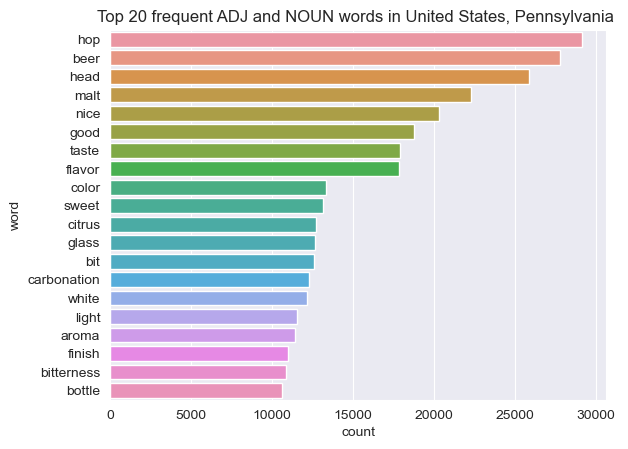

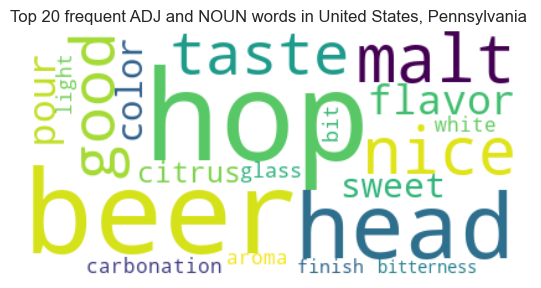

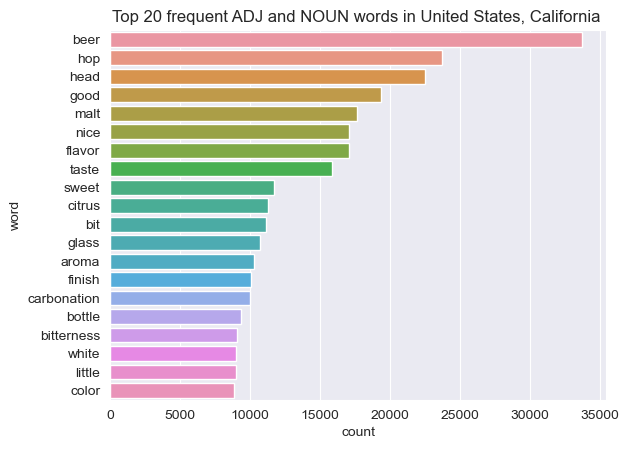

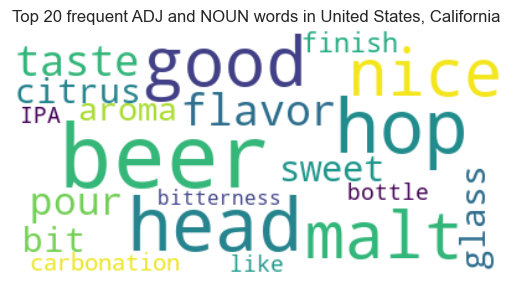

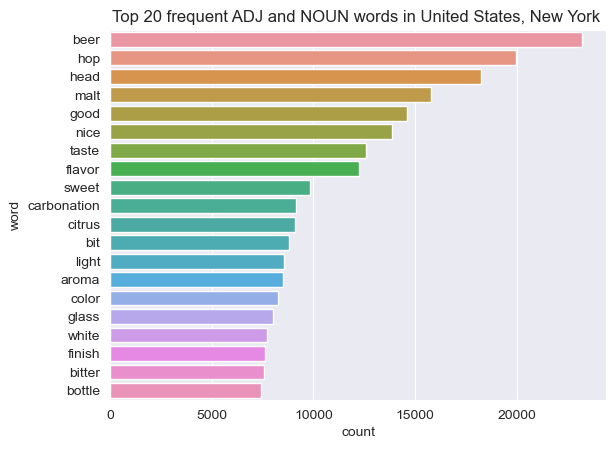

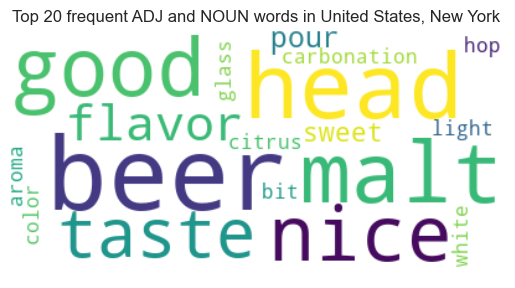

In [53]:
for region in most_popular_region:
    df_sentiment_ba_region = df_sentiment_ba[df_sentiment_ba['location'] == region]
    df_freq_word_region = Fine_Frequent_Words_Big(df_sentiment_ba_region)
    sns.barplot(x='count', y='word', data=df_freq_word_region[(df_freq_word_region['pos'] == 'ADJ') | (df_freq_word_region['pos'] == 'NOUN')].head(20))
    plt.title(f'Top 20 frequent ADJ and NOUN words in {region} ')
    plt.show()

    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
    words = {}
    for i in range(20):
        words[df_freq_word_region['word'][i]] = df_freq_word_region['count'][i]

    wordcloud = wordcloud.generate_from_frequencies(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Top 20 frequent ADJ and NOUN words in {region} ')
    plt.show()

## Trend Analysis on popular beer styles
We first want to do some analysis on beers, since we want to make popular beers, we first investigate top 3 style with the most number of reviews.

In [54]:
# make a copy of the dataframe, only retain the useful columns
df = region_ba_filtered.copy()
df = df.drop(columns=['user_name_y','review','joined','text','user_name_x','user_id'])
df['date'] = df.date.apply(lambda x: datetime.datetime.fromtimestamp(x).year)

In [55]:
# find the top 3 style with the most number of reviews
style_top_3 = df.groupby('style').count().reset_index().sort_values(by = 'beer_name', ascending=False)[['style']][:3]['style'].to_list()
style_top_3

['American IPA', 'American Double / Imperial IPA', 'American Porter']

We found that the top 3 style with the most number of reviews are American IPA, American Double / Imperial IPA, and American Pale Ale.

In [56]:
year_list = [i+1998 for i in range(20)]

In [57]:
temp_dict = {}
for style in style_top_3:
    temp_dict[style] = []
    for year in year_list:
        tempdf = df[df['style'] == style]
        year_count = len(tempdf[tempdf['date']==year])
        temp_dict[style].append(year_count)

Text(0.5, 0.98, 'The number of reviews of top 3 beer over time')

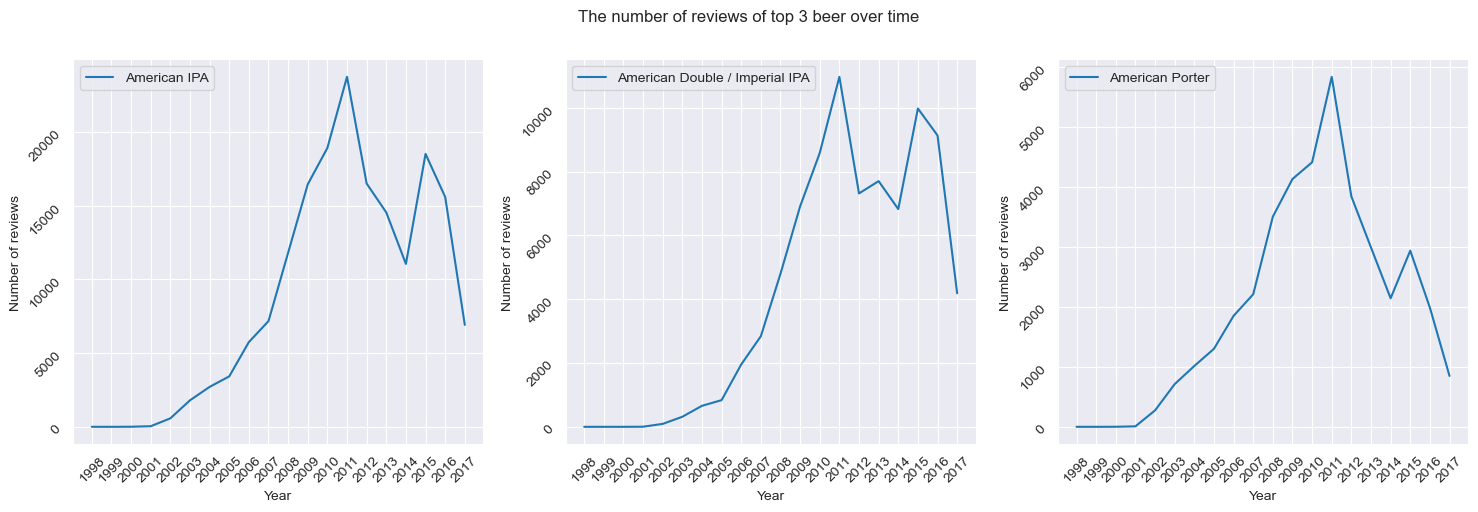

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(18,5))
for idx, key in enumerate(temp_dict.keys()):
    count = pd.DataFrame(temp_dict[key], year_list)
    sns.lineplot(x=count.index.astype(str), y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
    ax[idx].legend(prop={'size': 10})
    ax[idx].set_ylabel('Number of reviews')
    ax[idx].set_xlabel('Year')
    ax[idx].tick_params(labelrotation=45)
fig.suptitle("The number of reviews of top 3 beer over time")

We found that the number of review decreases after 2010, but why?
Let's then have a look at the total number of review in each year.

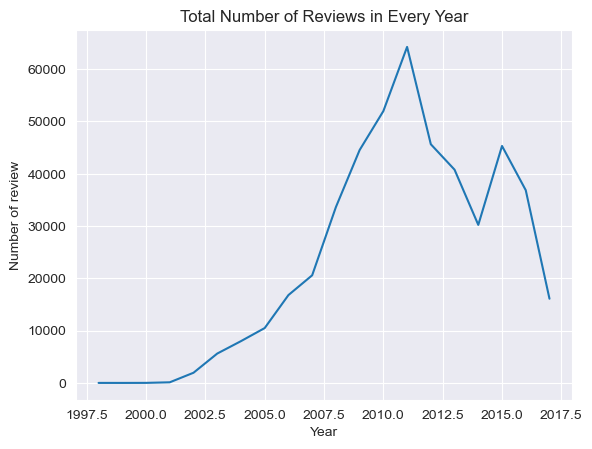

In [59]:
temp_list = []
for year in year_list:
    year_count = len(df[df['date']==year])
    temp_list.append(year_count)
temp_list = pd.DataFrame(temp_list, year_list)
sns.lineplot(x=temp_list.index, y=temp_list[0], data=temp_list)
plt.ylabel("Number of review")
plt.xlabel("Year")
plt.title("Total Number of Reviews in Every Year")
plt.show()

We can see that the total number of reviews is also decreasing, This may due to the number of active users on the website is decreasing. To factor this effect out, we use the fraction of the number of reviews of each style.G

In [84]:
def plot_style_style_frac_worldwide(style_top_3=style_top_3, year_list=year_list, prediction=False):
    fraction_dict_top3_style = {}
    for style in style_top_3:
        fraction_dict_top3_style[style] = []
        for year in year_list:
            year_tot = len(df[df.date == year])
            tempdf = df[df['style'] == style]
            year_frac = len(tempdf[tempdf['date']==year]) / year_tot
            fraction_dict_top3_style[style].append(year_frac)
    year_to_plot = year_list
    Y_to_plot = fraction_dict_top3_style
    if prediction:
        for style in style_top_3:
            x = year_list# train data x
            y = fraction_dict_top3_style[style]
            y = [i+1 for i in y]
            Y = pd.DataFrame(x, y).reset_index()

            X = [i for i in range(1,10)] ## 往后预测多少年
            fh = ForecastingHorizon(X, is_relative=True)
            forecaster = ThetaForecaster(sp=2)
            forecaster.fit(y=Y)
            y_pred = forecaster.predict(fh = fh)
            year_to_plot = year_list + [year_list[-1]] + y_pred[0].to_list()
            Y_to_plot[style].append(Y_to_plot[style][-1])
            Y_to_plot[style].extend(y_pred['index']-1)

    fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15,5))
    for idx, key in enumerate(Y_to_plot.keys()):
        count = pd.DataFrame(Y_to_plot[key], year_to_plot)
        # print(count.index)
        # print(count[0])
        sns.lineplot(x=count.index[:len(year_list)], y=count[0].iloc[:len(year_list)], data=count.iloc[:len(year_list)], ax = ax[idx], legend=True, label= key, palette="rainbow")
        sns.lineplot(x=count.index[len(year_list):], y=count[0].iloc[len(year_list):], data=count.iloc[len(year_list):], ax = ax[idx], legend=True, label= key+" predicted", palette="rainbow")

        ax[idx].legend(prop={'size': 10})
        ax[idx].set_ylabel('Number of reviews / Total reviews')
        ax[idx].set_xlabel('Year')
    if prediction:
        fig.suptitle("Prediction about fraction of beer style for top 3")
    else:
        fig.suptitle("The fraction of beer style for top 3")

Plot with prediction

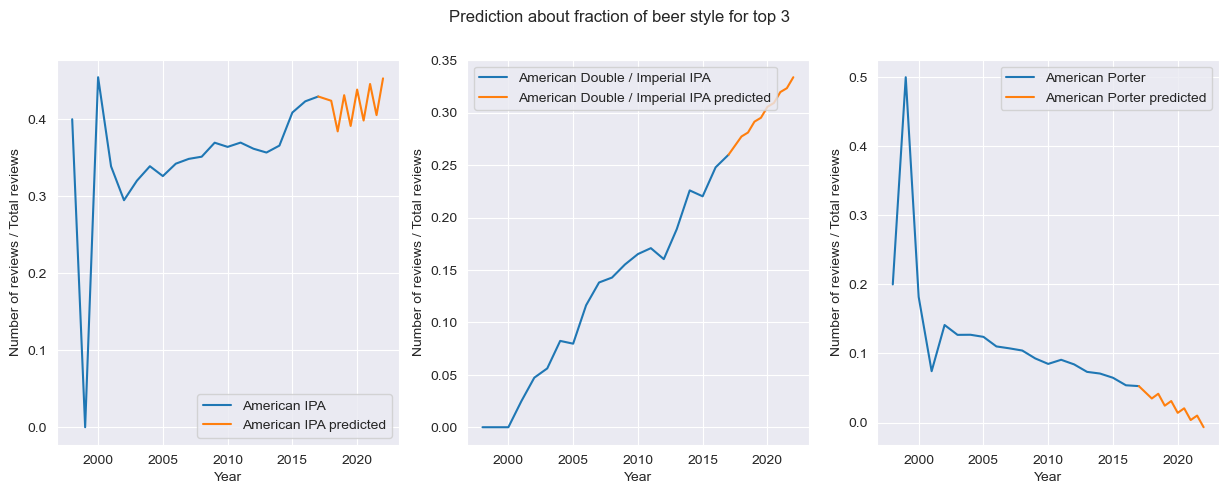

In [85]:
plot_style_style_frac_worldwide(style_top_3, year_list,True)

Plot without prediction

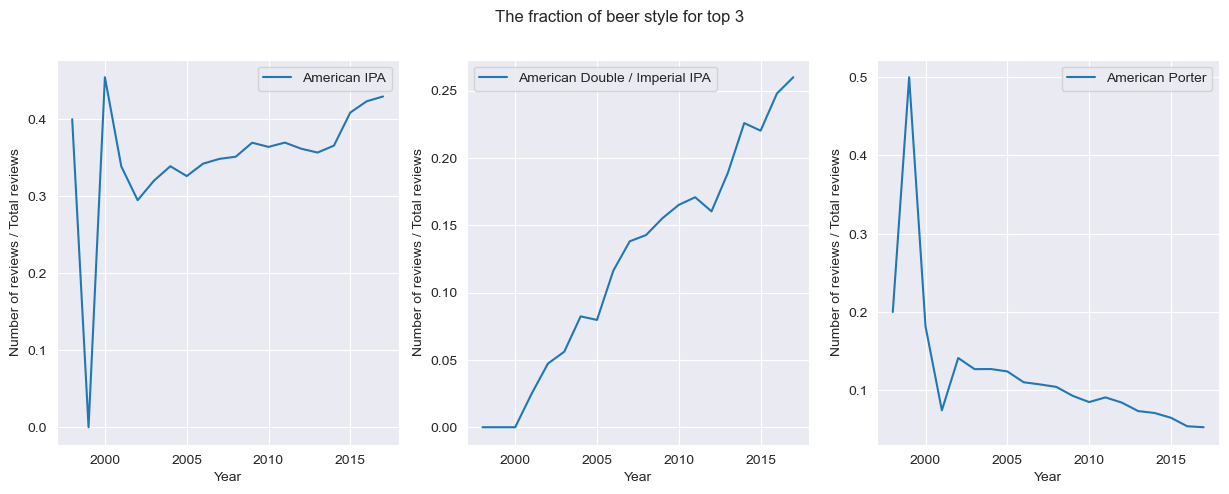

In [86]:
plot_style_style_frac_worldwide(style_top_3, year_list)

Now this can reveal the trend, we can learn that "American IPA" and "American Double/Imperial"" IPA's number of reviews are increasing worldwide, while that of "American Porter" is becoming less dominant.

**Next step: find and analyze the reasons behind the above trend.**
**_(May have a look at the trend of the number of positive, negative reviews of that styles in each year_**


Here, we may tell that the breweries should lay more emphasis on the production of beers of type "American IPA" and "American Double/Imperial IPA", while give less attention to the production of "American Porter" Beer.

In [63]:
df.columns

Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating',
       'nbr_ratings', 'nbr_reviews', 'location'],
      dtype='object')

In [64]:
# define the function to plot the top 5 regions that have reviews of one particular type
def plot_style_region(style=None, number_regions=5, data_frame=df):

    data = data_frame[data_frame['style'] == style]
    region_list = data[['location', 'beer_id']].groupby('location').agg('count')
    region_list.rename(columns={'beer_id': 'count'}, inplace=True)
    region_list = region_list.sort_values(by='count', ascending=False)
    region_list.reset_index(inplace=True)
    region_list = region_list.iloc[:number_regions]['location'].to_list()
    # print(region_list)
    fraction_dict_top_regions = {}
    if number_regions <= 5:
        fig, ax = plt.subplots(1, number_regions, figsize = (30, 5))
    else:
        fig, ax = plt.subplots(number_regions//5 , 5, figsize = (30, 5*number_regions//5 + 1))
    plt.title(f'The fraction of reviews of {style} in top {number_regions} regions')
    for location in region_list:
        fraction_dict_top_regions[location] = []
        for year in year_list:
            temp = data_frame[data_frame['date']==year]
            num_reviews_region_year = len(temp[temp['location']==location])
            temp2 = data[data['date']==year]
            if num_reviews_region_year == 0:
                frac_reviews_style_region_year = 0
            else:
                frac_reviews_style_region_year = len(temp2[temp2['location']==location]) / num_reviews_region_year
            fraction_dict_top_regions[location].append(frac_reviews_style_region_year)
    for idx, key in enumerate(fraction_dict_top_regions.keys()):
        count = pd.DataFrame(fraction_dict_top_regions[key], year_list)
        if number_regions > 5:
            sns.lineplot(x=count.index, y=count[0], data=count, ax = ax[math.floor(idx/5), idx%5], legend=True, label= key, palette='rainbow')
            ax[math.floor(idx//5), idx%5].legend(prop={'size': 20})
            ax[math.floor(idx//5), idx%5].set_ylabel('Number of reviews / Total reviews')
            ax[math.floor(idx//5), idx%5].set_xlabel('Year')
            ax[math.floor(idx//5), idx%5].set_title(key)
        else:
            sns.lineplot(x=count.index, y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
            ax[idx].legend(prop={'size': 20})
            ax[idx].set_ylabel('Number of reviews / Total reviews')
            ax[idx].set_xlabel('Year')
            ax[idx].set_title(key)

Plot the style change in 15 different regions for the top 3 styles

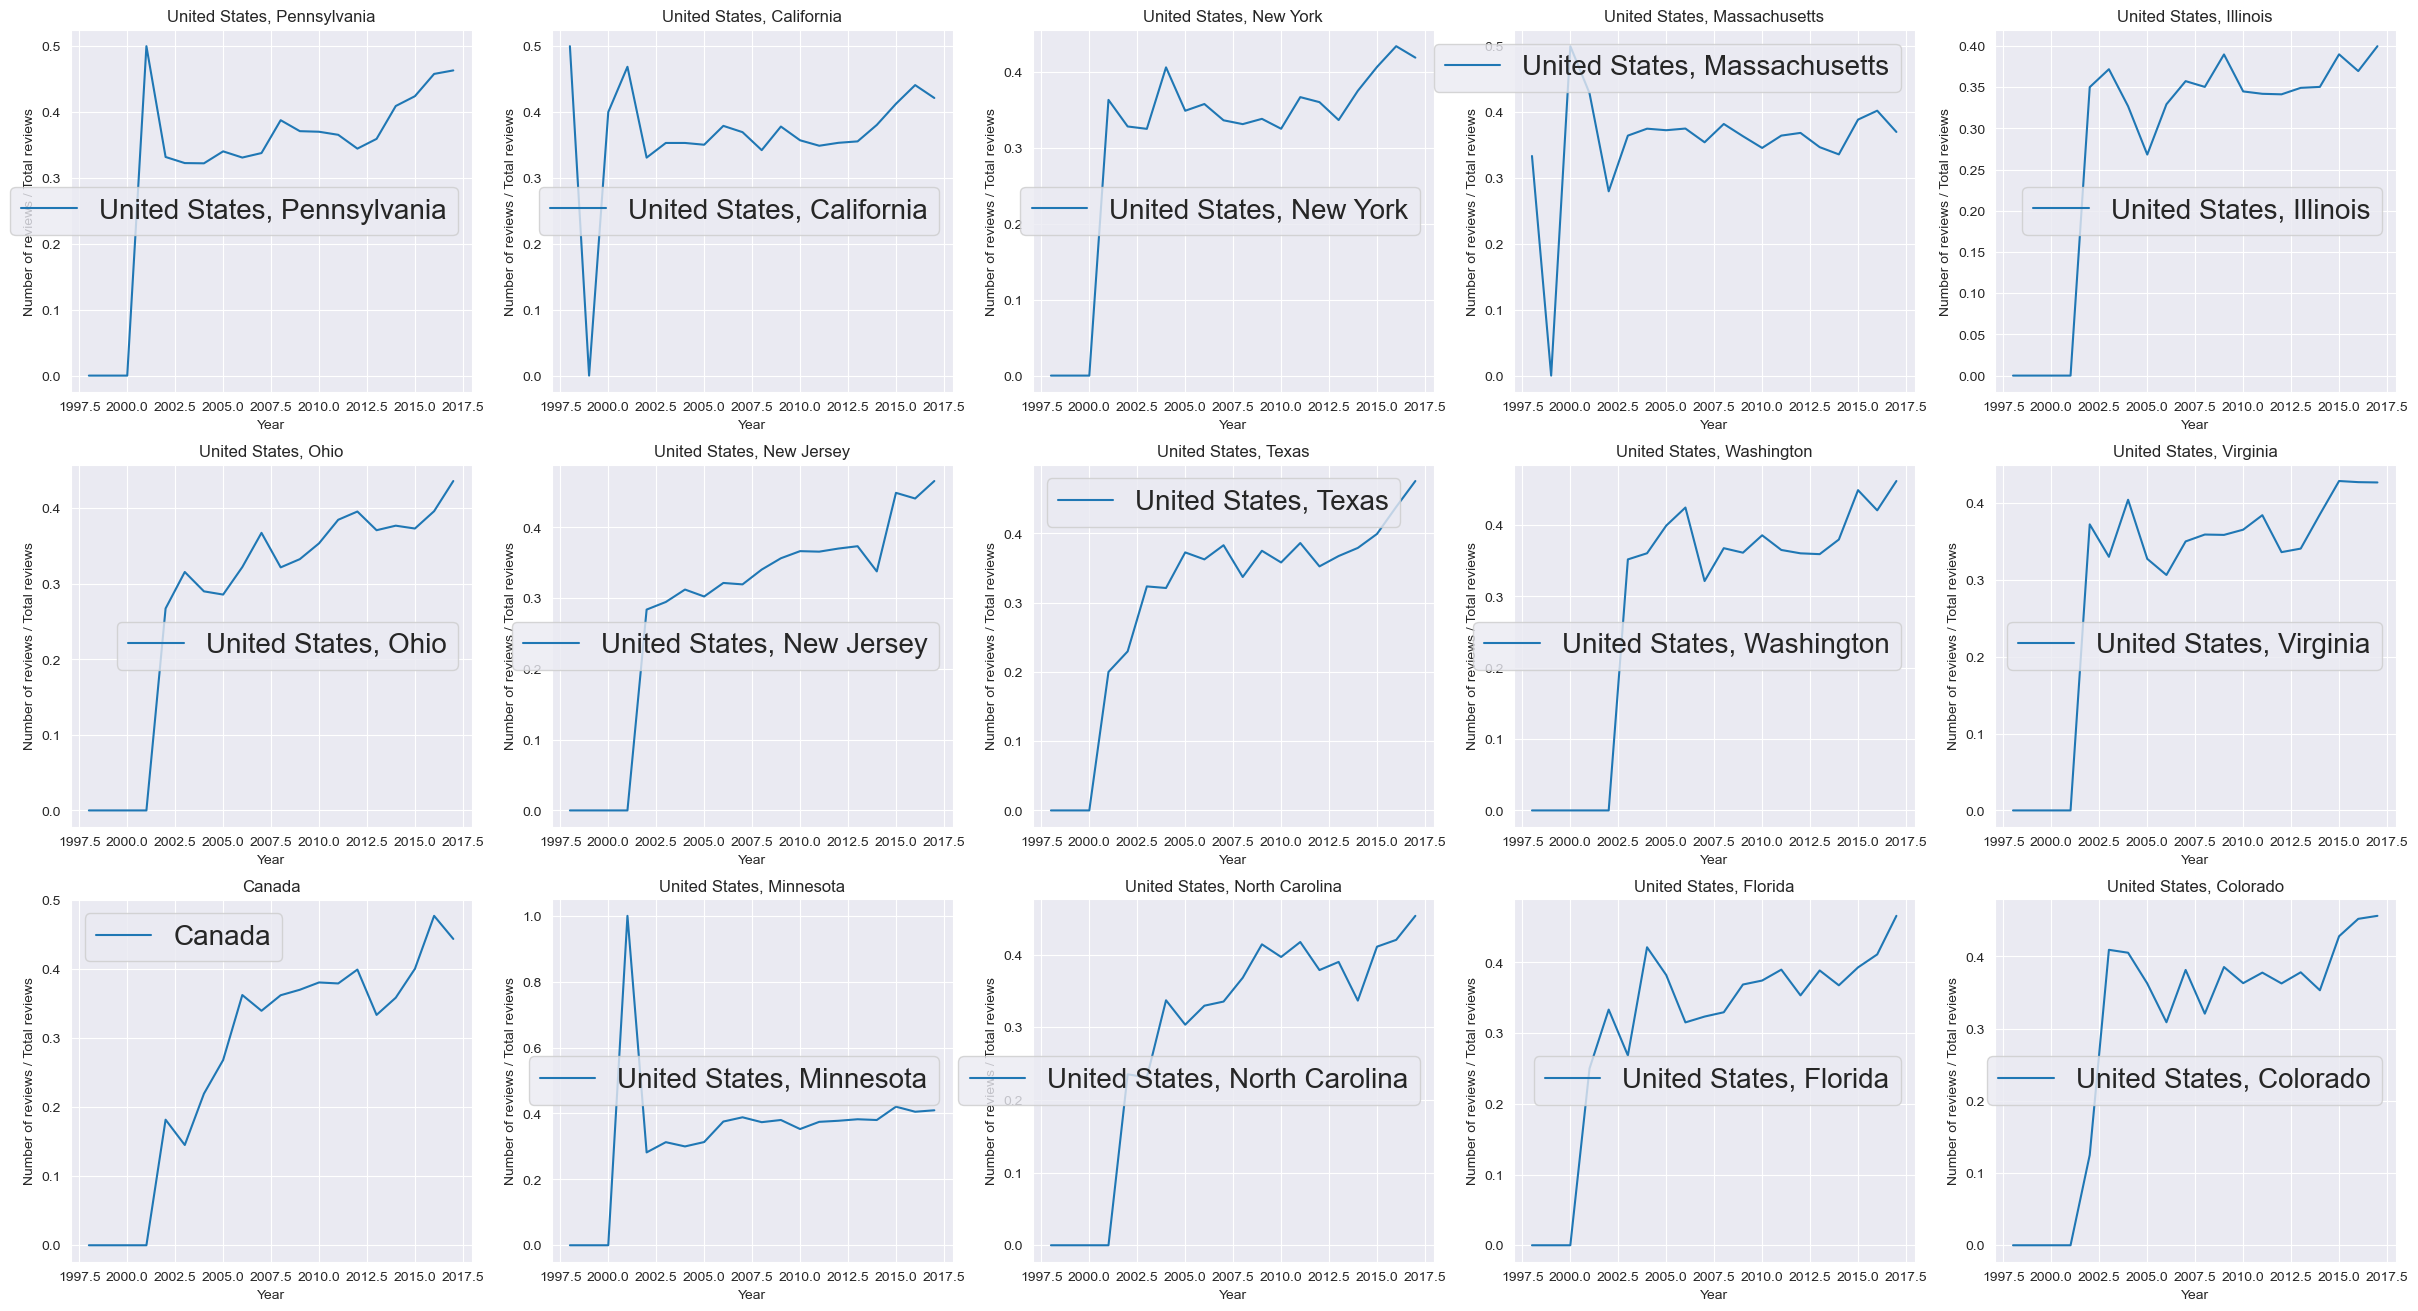

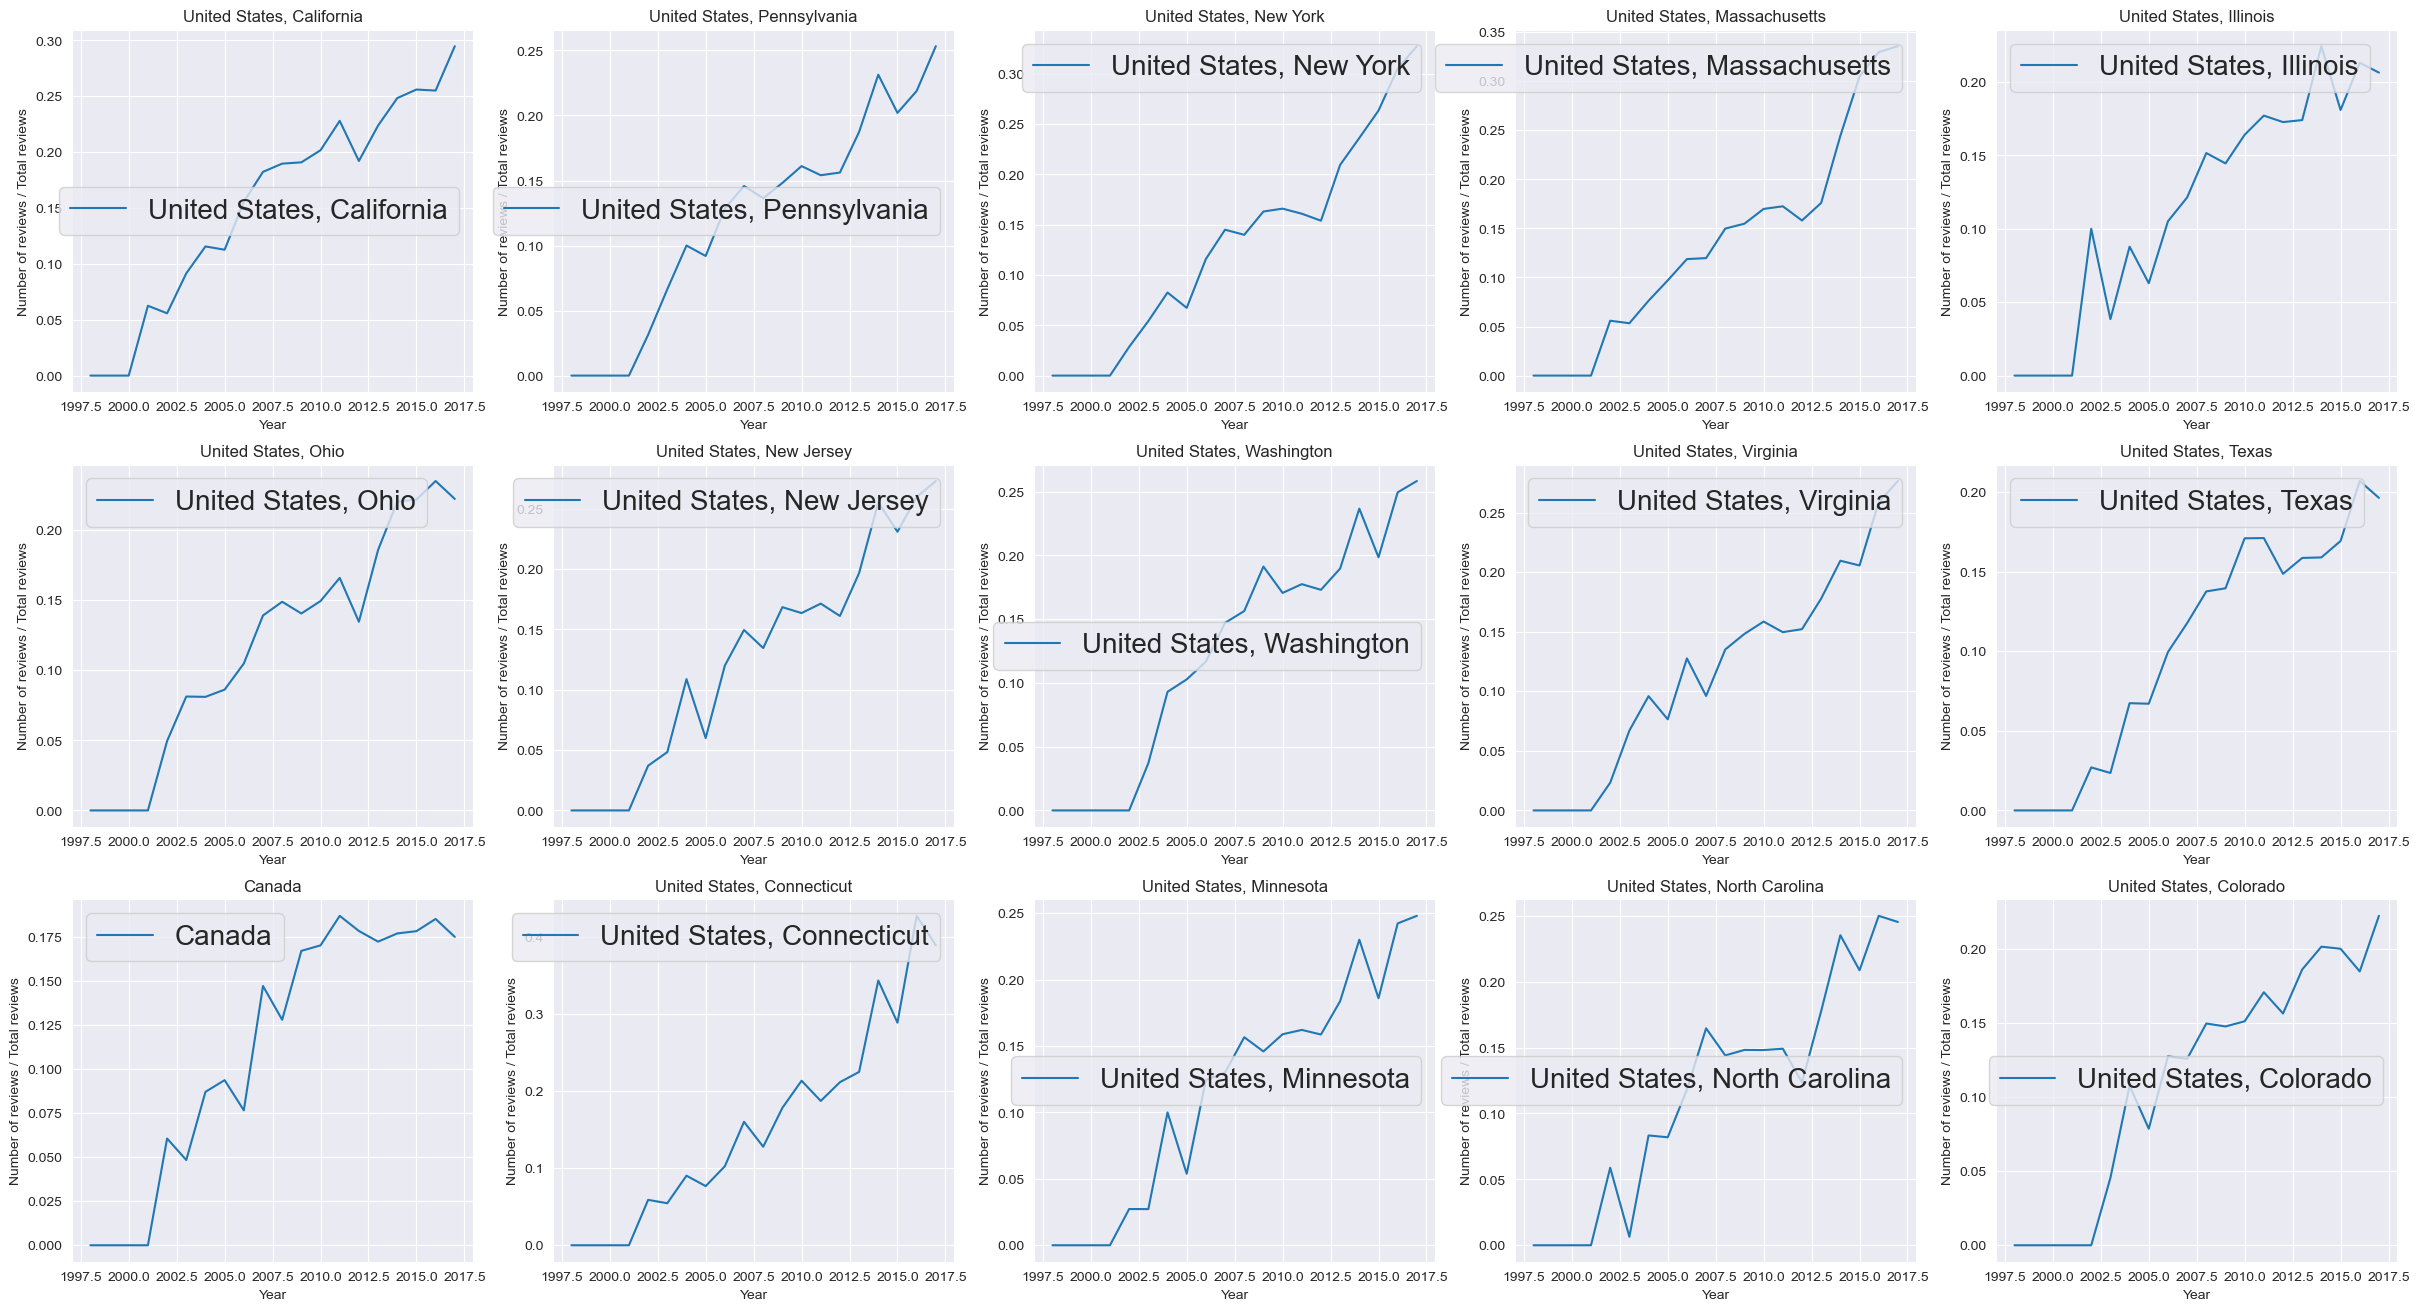

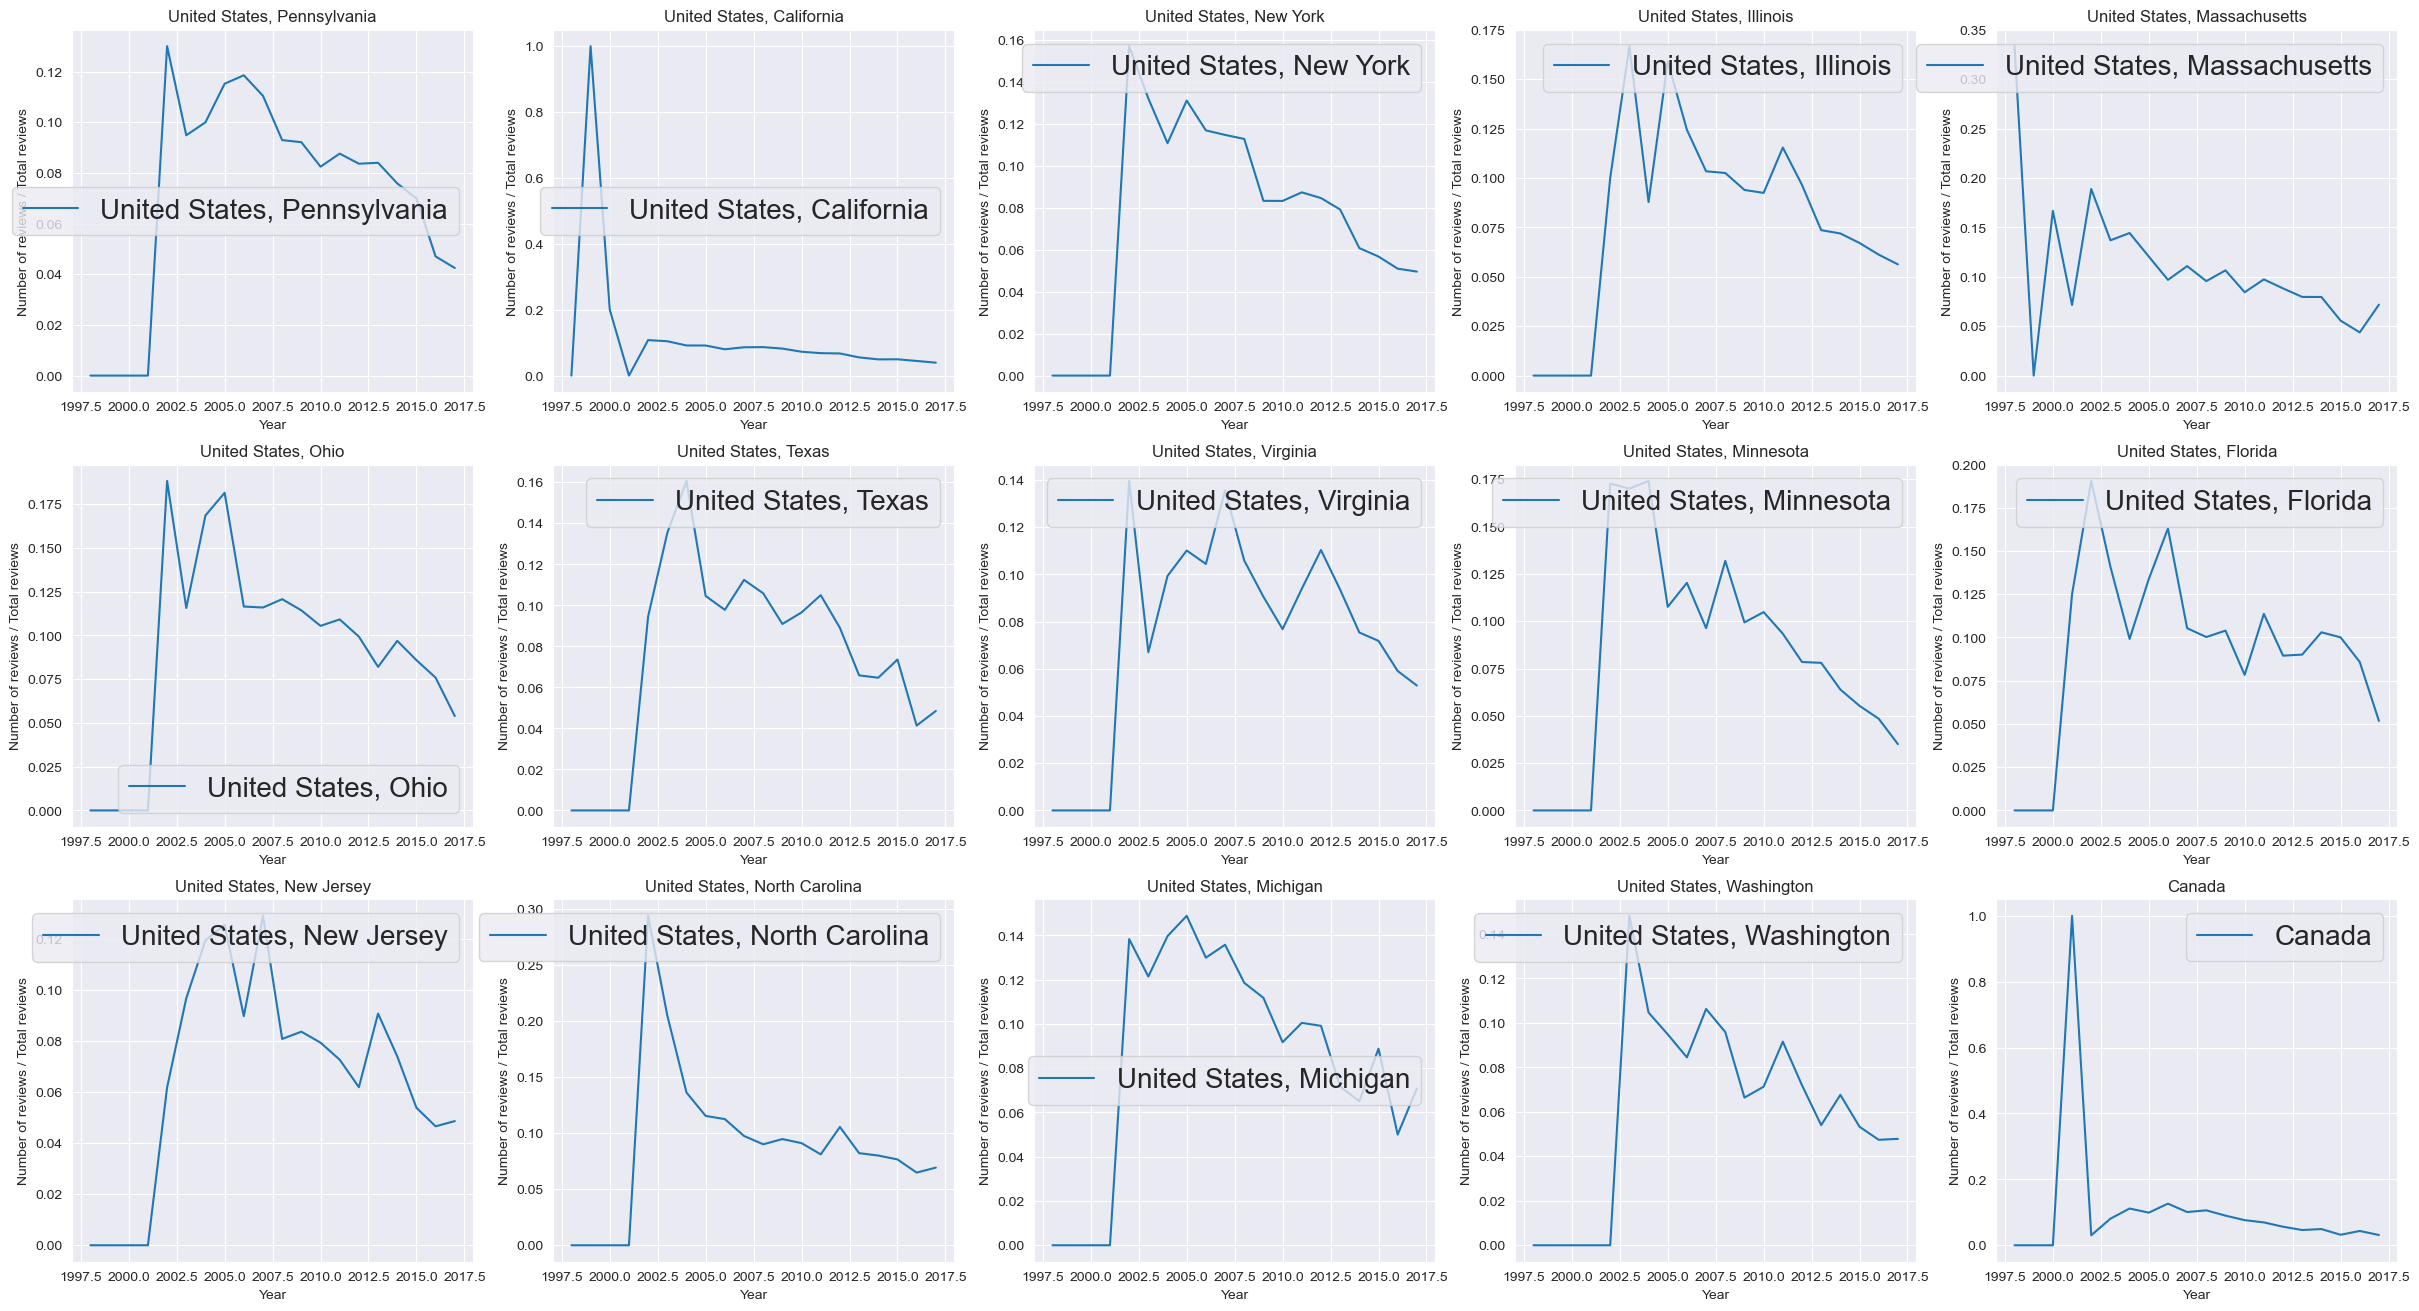

In [65]:
for style in style_top_3:
    plot_style_region(style, 15, df)

NEXT: **Give suggestions to breweries**
**_Find the relationship between the fraction of reviews and the fraction of negative reviews_**
Combine the sentiment analysis with the style analysis

Combined with the analysis and the information found on the internet (we present on our website), we found that there is difference some features like the color and the hop.
For example, more yellow and golden beer are more popular than back and darker ones, and more refreshing and bitter hop are also becoming more and more popular.

ALE style分析

In [66]:
df_2 = region_ba_filtered.copy()
df_2 = df_2.drop(columns=['user_name_y','review','joined','text','user_name_x','user_id'])
df_2['date'] = df_2.date.apply(lambda x: datetime.datetime.fromtimestamp(x).year)

In [67]:
df_2.groupby('style').count().reset_index().sort_values(by = 'beer_name',ascending=False)[['style']]

style
3                      American IPA
1    American Double / Imperial IPA
5                   American Porter
9            Saison / Farmhouse Ale
4           American Pale Ale (APA)
0          American Amber / Red Ale
6           Belgian Strong Dark Ale
2  American Double / Imperial Stout
8            Russian Imperial Stout
7            Fruit / Vegetable Beer

Darker less bitter

In [68]:
style_ale = ['American Amber / Red Ale','American Pale Ale (APA)','Belgian Strong Dark Ale','Saison / Farmhouse Ale']
style_ale

['American Amber / Red Ale',
 'American Pale Ale (APA)',
 'Belgian Strong Dark Ale',
 'Saison / Farmhouse Ale']

In [69]:
year_list = [i+1998 for i in range(20)]

In [70]:
temp_dict2 = {}
for style in style_ale:
    temp_dict2[style] = []
    for year in year_list:
        tempdf_2 = df_2[df_2['style'] == style]
        year_count = len(tempdf_2[tempdf_2['date']==year])
        temp_dict2[style].append(year_count)

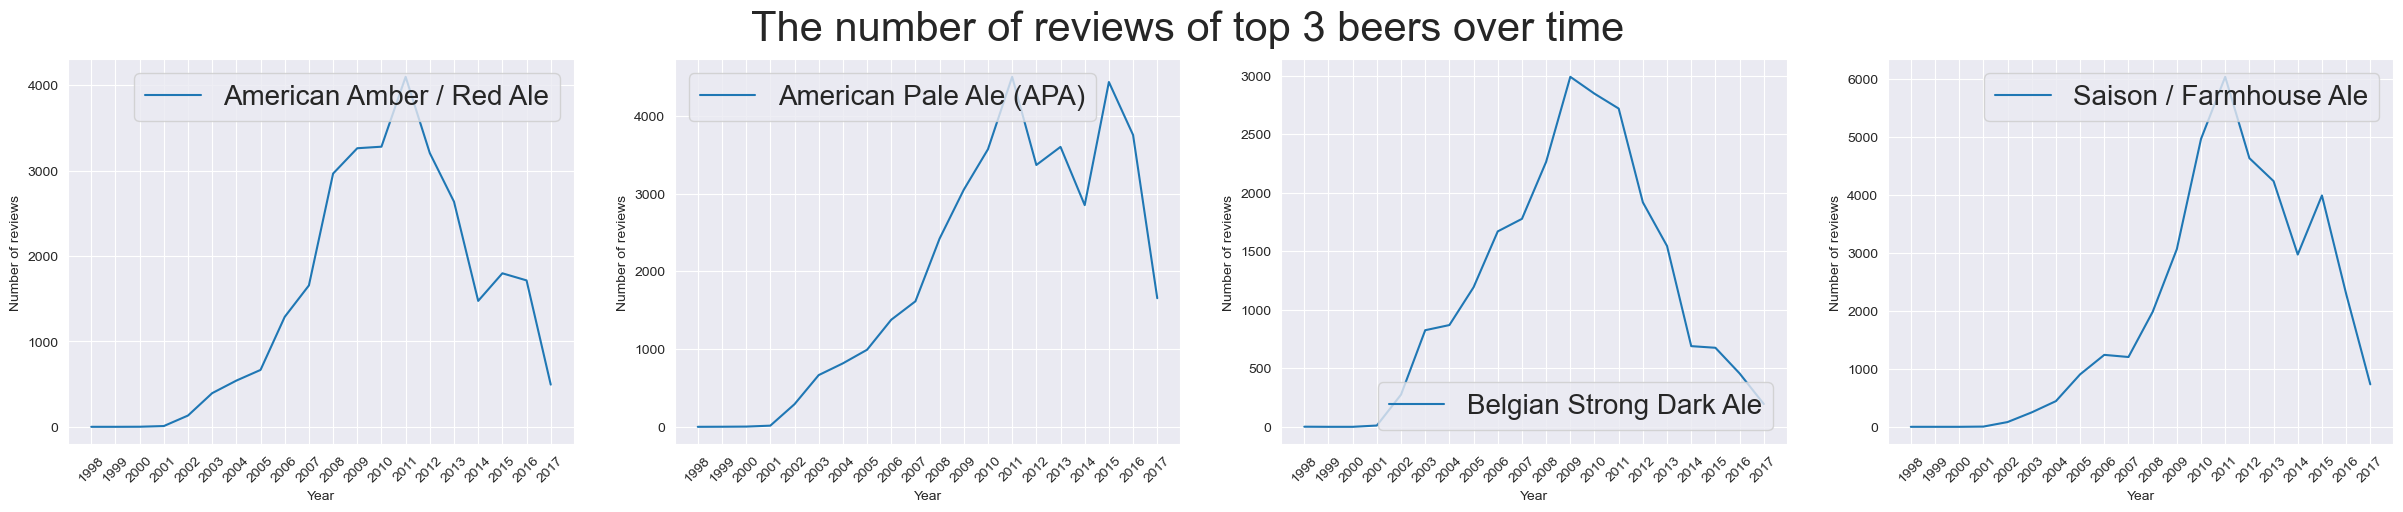

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(30,5))
for idx, key in enumerate(temp_dict2.keys()):
    count = pd.DataFrame(temp_dict2[key], year_list)
    sns.lineplot(x=count.index.values.astype(str), y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
    ax[idx].legend(prop={'size': 20})
    ax[idx].set_ylabel('Number of reviews')
    ax[idx].set_xlabel('Year')
    ax[idx].set_xticklabels(count.index.values.astype(str), rotation=45)
fig.suptitle("The number of reviews of top 3 beers over time ", fontsize=30)
plt.show()

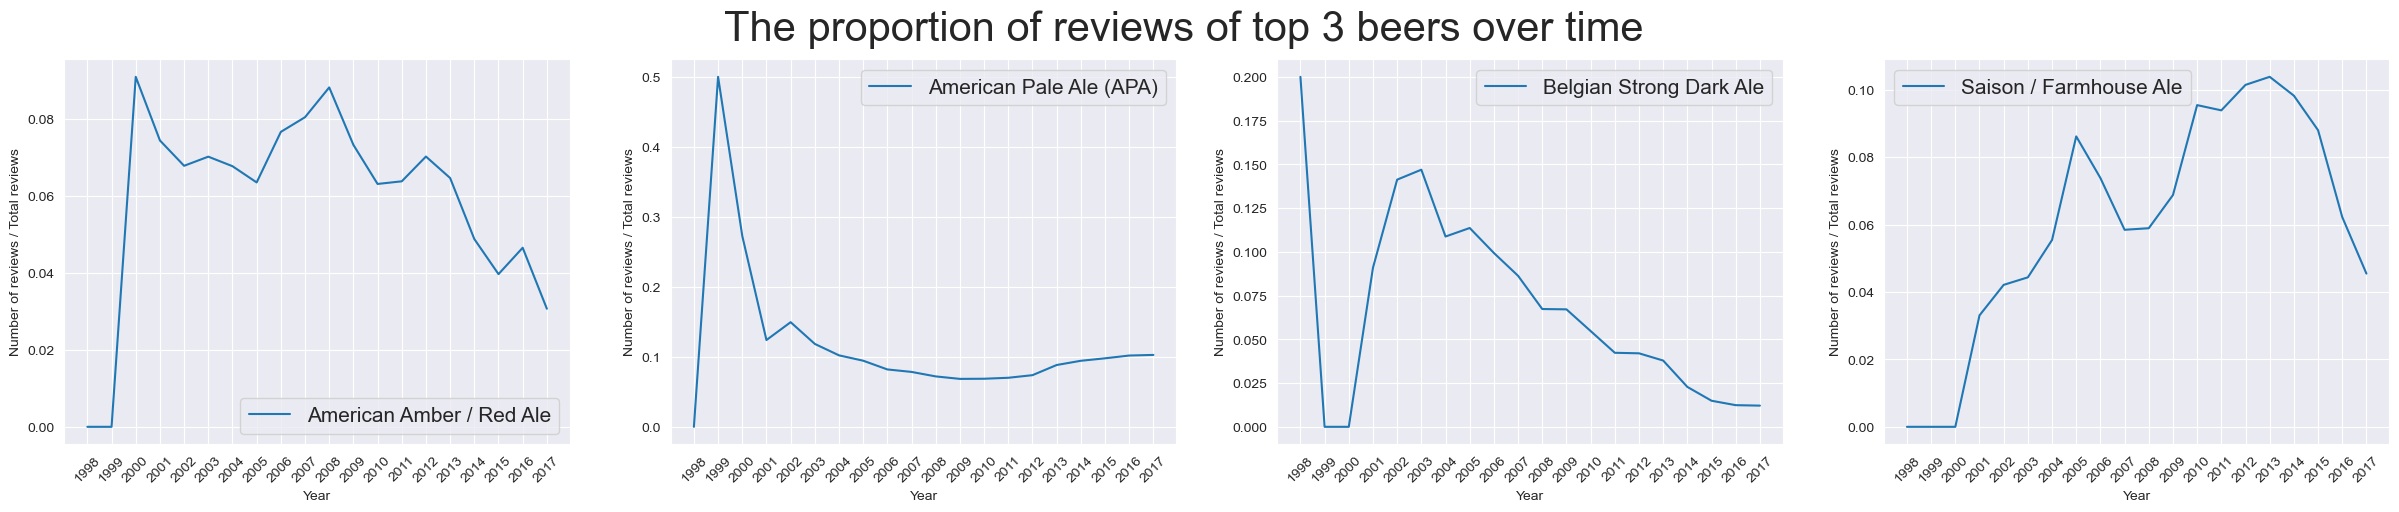

In [72]:
fraction_dict_style_ale = {}
for style in style_ale:
    fraction_dict_style_ale[style] = []
    for year in year_list:
        year_tot = len(df_2[df_2.date == year])
        tempdf_2 = df_2[df_2['style'] == style]
        year_frac = len(tempdf_2[tempdf_2['date']==year]) / year_tot
        fraction_dict_style_ale[style].append(year_frac)

fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(30,5))
for idx, key in enumerate(fraction_dict_style_ale.keys()):
    count = pd.DataFrame(fraction_dict_style_ale[key], year_list)
    sns.lineplot(x=count.index.astype(str), y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
    ax[idx].legend(prop={'size': 15})
    ax[idx].set_ylabel('Number of reviews / Total reviews')
    ax[idx].set_xlabel('Year')
    ax[idx].set_xticklabels(count.index.values.astype(str), rotation=45)
fig.suptitle("The proportion of reviews of top 3 beers over time ", fontsize=30)
plt.show()

In [73]:
def plot_style_region(style=None, number_regions=5, data_frame=df):

    data = data_frame[data_frame['style'] == style]
    region_list = data[['location', 'beer_id']].groupby('location').agg('count')
    region_list.rename(columns={'beer_id': 'count'}, inplace=True)
    region_list = region_list.sort_values(by='count', ascending=False)
    region_list.reset_index(inplace=True)
    region_list = region_list.iloc[:number_regions]['location'].to_list()
    # print(region_list)
    fraction_dict_top_regions = {}
    if number_regions <= 5:
        fig, ax = plt.subplots(1, number_regions, figsize = (60, 5))
    else:
        fig, ax = plt.subplots(number_regions//5, 5, figsize = (60, 5))
    for location in region_list:
        fraction_dict_top_regions[location] = []
        for year in year_list:
            temp = data_frame[data_frame['date']==year]
            num_reviews_region_year = len(temp[temp['location']==location])
            temp2 = data[data['date']==year]
            if num_reviews_region_year == 0:
                frac_reviews_style_region_year = 0
            else:
                frac_reviews_style_region_year = len(temp2[temp2['location']==location]) / num_reviews_region_year
            fraction_dict_top_regions[location].append(frac_reviews_style_region_year)
    for idx, key in enumerate(fraction_dict_top_regions.keys()):
        count = pd.DataFrame(fraction_dict_top_regions[key], year_list)
        if number_regions > 5:
            sns.lineplot(x=count.index.astype(str), y=count[0], data=count, ax = ax[math.floor(idx//5), idx%5], legend=True, label= key, palette='rainbow')
            ax[math.floor(idx//5), idx%5].legend(prop={'size': 20})
            ax[math.floor(idx//5), idx%5].set_ylabel('Number of reviews / Total reviews')
            ax[math.floor(idx//5), idx%5].set_xlabel('Year')
            ax[math.floor(idx//5), idx%5].set_title(key)
        else:
            sns.lineplot(x=count.index.astype(str), y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
            ax[idx].legend(prop={'size': 15})
            ax[idx].set_ylabel('Number of reviews / Total reviews')
            ax[idx].set_xlabel('Year')
        ax[idx].set_xticklabels(count.index.values.astype(str), rotation=45)

        fig.suptitle(f'The fraction of reviews of {style} in top {number_regions} regions', fontsize=30)


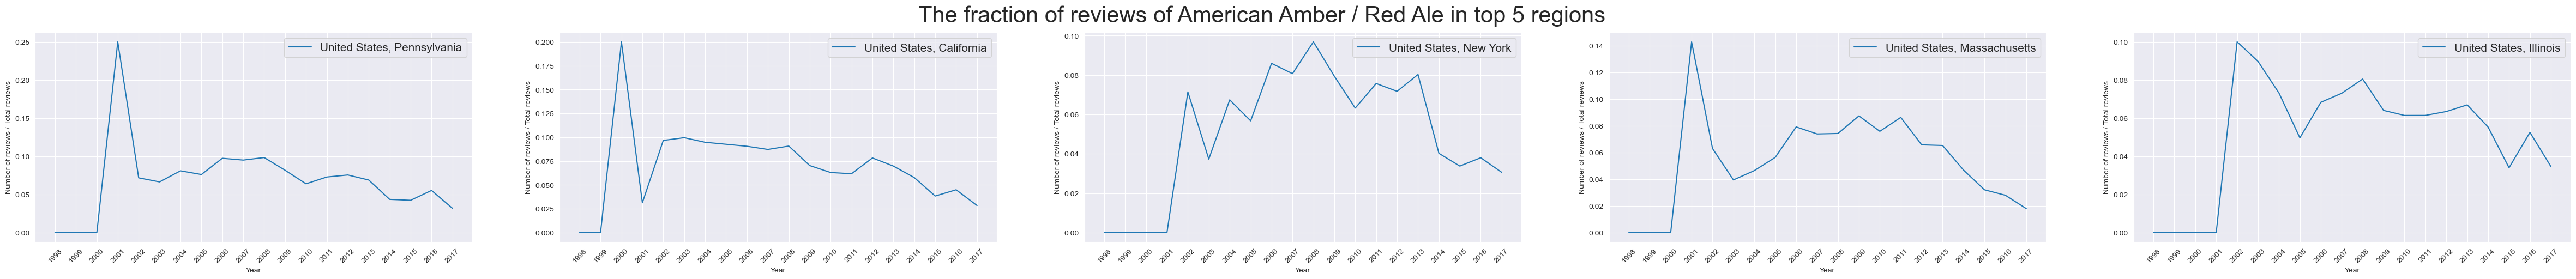

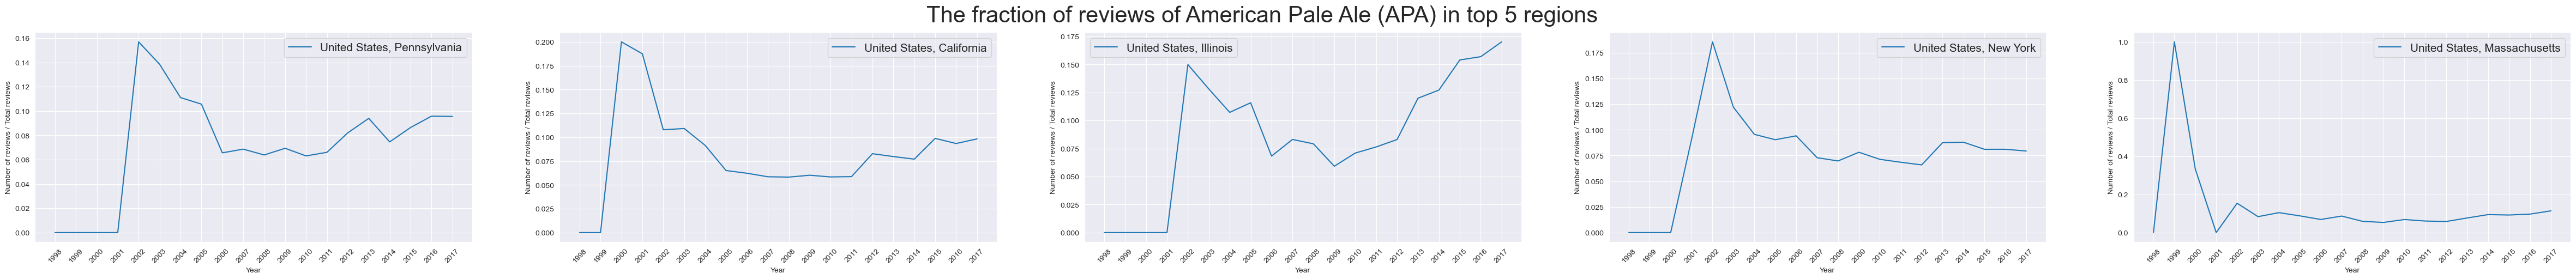

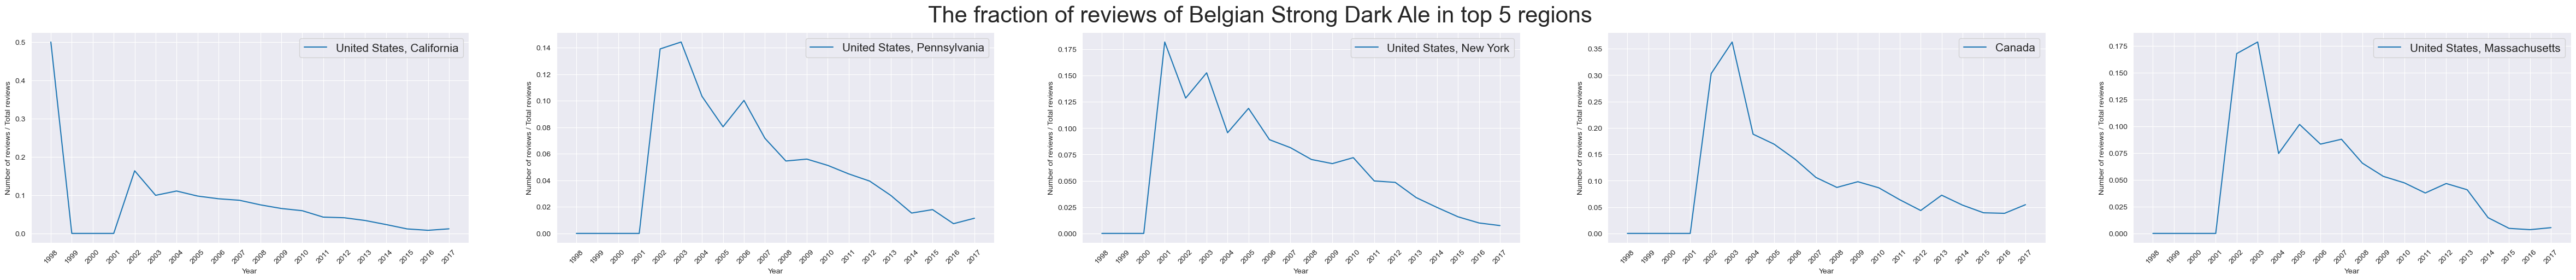

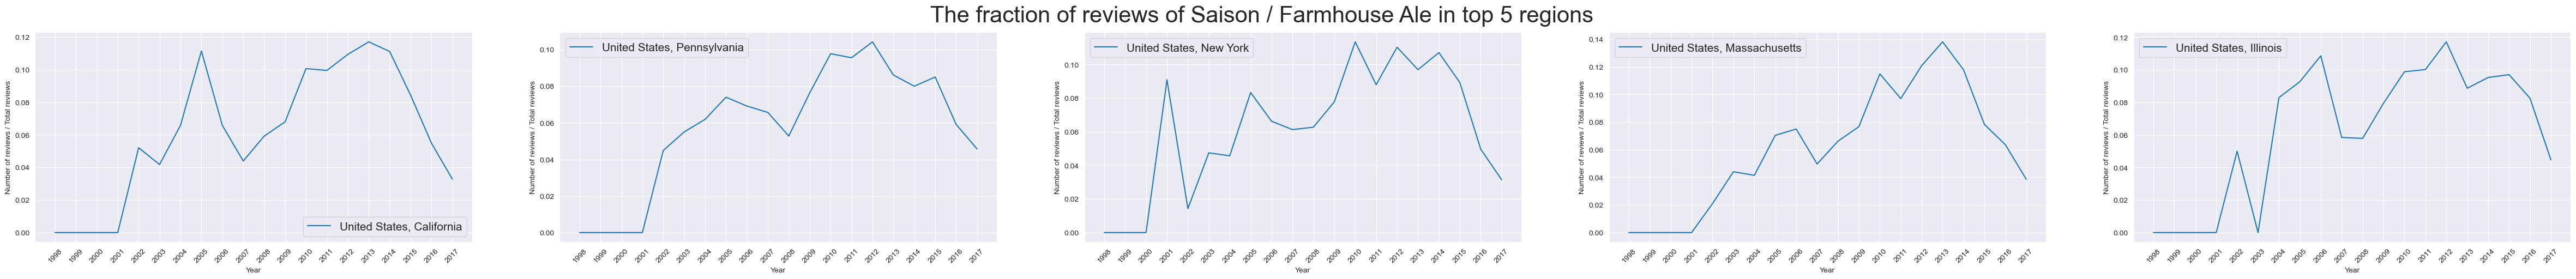

In [74]:
for style in style_ale:
    plot_style_region(style, 5, df_2)

### User Protrait combined with the last part of the Sentiment Analysis Section

In [75]:
region_ba_style_change = region_ba_filtered.copy()


In [76]:
region_ba_style_change.date = region_ba_style_change.date.apply(lambda x: datetime.datetime.fromtimestamp(x).year)


In [77]:
regions = region_agg.location[:10]


Draw an animation

In [78]:
for region in regions:
    df_race = region_ba_style_change[(region_ba_style_change.location == region)][['style','rating', 'date', 'location']]
    df_race = df_race.set_index(['date']).sort_index()
    df_race = df_race.groupby(['date', 'style']).sum()
    pivot_tab = pd.pivot_table(df_race, index='date', columns='style', values='rating')
    bcr.bar_chart_race(
        df=pivot_tab,
        filename=f'./{region}.gif',
        orientation='h',
        sort='desc',
        n_bars=8,
        fixed_order=False,
        fixed_max=True,
        steps_per_period=20,
        period_length=500,
        interpolate_period=False,
        period_label={'x': .98, 'y': .3, 'ha': 'right', 'va': 'center'},
        period_summary_func=lambda v, r: {'x': .98, 'y': .2,
                                          's': f'Total preference: {v.sum():,.0f}',
                                          'ha': 'right', 'size': 11},
        perpendicular_bar_func='median',
        title=region,
        bar_size=.95,
        shared_fontdict=None,
        scale='linear',
        fig=None,
        writer=None,
        bar_kwargs={'alpha': .7},
        filter_column_colors=False)

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
